In [521]:
from ipywidgets import interact, FloatSlider, RadioButtons,Dropdown,SelectMultiple,FloatRangeSlider
import gc, argparse, sys, os, errno
%pylab inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import h5py
import os
import scipy
import sklearn
from scipy.stats import pearsonr
from sklearn.metrics import roc_curve,roc_auc_score
import warnings
warnings.filterwarnings('ignore')
from ipywidgets import interact, FloatSlider,IntSlider, RadioButtons,Dropdown,Tab,Text
styles = ["white","dark",'whitegrid',"darkgrid"]
contexts = ['paper','talk','poster','notebook']
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from  sklearn import preprocessing
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc
tableau20 = np.array([(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),  
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),  
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),  
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),  
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)])/255.

Populating the interactive namespace from numpy and matplotlib


In [3]:
pwd

'/home/chenxupeng/projects/training'

In [4]:
wholeannotation = pd.read_table("wholeannotation.csv",sep=',')
wholeannotation.head()

,Unnamed: 0,Sample_ID,Disease_status,Sex,Age,Tumor_size(cm),Multiple_tumor,Vascular_invasion,Satellite_nonules,AFP(ng/ml),...,PT,Stage-BCLC,RNA_mass(ng/mlplasma),Batch,spike-in,Seq-mode,DNase1,use,sampleuse,Disease_status_formal
0,0,lulab_249136_B,HCC_before_surgery,M,43,2.8,No,No,0,559.6,...,10.1,A,27.63,7th_201803,NaN,NaN,NaN,1,1,HCC
1,1,lulab_385247_B,HCC_before_surgery,M,54,4,No,No,1,19.61,...,12,A,33.45,4th_201801,NaN,NaN,NaN,1,1,HCC
2,2,lulab_423976_B,HCC_before_surgery,F,60,_,No,Yes,0,4.58,...,15,C,32.66,3nd_201801,NaN,NaN,NaN,1,1,HCC
3,3,lulab_497411_B,HCC_before_surgery,F,70,8,No,No,0,3.45,...,11.3,A,28.32,2nd_201712,0,PE150,N,1,1,HCC
4,4,lulab_497497_B,HCC_before_surgery,M,44,12.3,Yes,No,0,3155,...,11.2,B,34.24,1st_201711,0,PE150,N,1,1,HCC


# feature selection
use after normalization

## prepare data
- main and top20
- preprocess

In [5]:
##注意： 经过检验，normalization步骤的sample use是没问题的，在前64个sample中去掉三个sample，这里wholeanno是66个sample，
##在前64个有三个去掉，再去掉post的即为需要的
sampleinduse = np.array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13,14,  15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 58, 59, 60])

In [6]:
np.where(wholeannotation['sampleuse'] ==1)[0][:-2]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59, 60, 61, 62, 63])

#### 需要的43个sample的table！

In [7]:
#需要的43个sample的table！
usetable = wholeannotation.iloc[np.where(wholeannotation['sampleuse'] ==1)[0][:-2]].iloc[sampleinduse]

In [8]:
np.sum(usetable['Disease_status_formal'] =='HCC')

30

In [9]:
def get_data(full=True):
    if full:
        featuretable=  pd.read_table('05.matrix/forfeatureselectionbynorm_61samplefull.csv',sep=',').iloc[:,1:].iloc[sampleinduse,:]
        featuretable['lables'][featuretable['lables'] ==2]=0
        return featuretable
    else:
        featuretable =  pd.read_table('05.matrix/forfeatureselectionbynorm_61samplebinned.csv',sep=',').iloc[:,1:].iloc[sampleinduse,:]
        featuretable['lables'][featuretable['lables'] ==2]=0
        return featuretable
def top20_data(full=True):
    if full:
        return np.array(pd.read_table('05.matrix/forfeatureselectionbynorm_61samplefulltop20.csv',sep=',').iloc[:,1:].iloc[:,sampleinduse]).T
    else:
        return np.array(pd.read_table('05.matrix/forfeatureselectionbynorm_61samplebinnedtop20.csv',sep=',').iloc[:,1:].iloc[:,sampleinduse]).T
def get_concat_data(top20,main):
    main[np.isnan(main)] =0
    print (preprocessing.scale(top20).shape)
    print (preprocessing.scale(main).shape)
    fullfeaturesarray =np.concatenate((preprocessing.scale(main),
                               preprocessing.scale(top20),
                ),axis=1)
    print (fullfeaturesarray.shape)
    return fullfeaturesarray   

In [10]:
fullfeaturename = np.concatenate((get_data(full=True).columns[2:],
                np.array(pd.read_table('05.matrix/forfeatureselectionbynorm_61samplefulltop20.csv',sep=',').iloc[:,0])))
binfeaturename = np.concatenate((get_data(full=False).columns[2:],
                np.array(pd.read_table('05.matrix/forfeatureselectionbynorm_61samplebinnedtop20.csv',sep=',').iloc[:,0])))
mixfeaturename = np.concatenate((fullfeaturename,binfeaturename))

In [11]:
np.savetxt('top20featurebin_full.txt',np.concatenate((np.array([np.array(pd.read_table('binnedtop20.csv'))[i][0].split(',')[1][1:-1] for i in range(20)]).reshape(-1,1),
np.array([np.array(pd.read_table('fulltop20.csv'))[i][0].split(',')[1][1:-1] for i in range(20)]).reshape(-1,1)),axis=1),fmt='%s')



In [12]:
binfeaturenamesplit = np.array([binfeaturename[i].split('__')[0] for i in range(binfeaturename.shape[0])]).astype('object')
mixfeaturenamesplit = np.concatenate((fullfeaturename,binfeaturenamesplit)).astype('object')
fullfeaturesarray = get_concat_data(top20_data(full=True),np.array(get_data(full=True).iloc[:,2:]))
binfeaturesarray = get_concat_data(top20_data(full=False),np.array(get_data(full=False).iloc[:,2:]))
mixfeaturesarray = np.concatenate((fullfeaturesarray,binfeaturesarray),axis=1)
mixfeaturesarray.shape

In [13]:
fullfeaturesarray = get_concat_data(top20_data(full=True),np.array(get_data(full=True).iloc[:,2:]))
binfeaturesarray = get_concat_data(top20_data(full=False),np.array(get_data(full=False).iloc[:,2:]))
mixfeaturesarray = np.concatenate((fullfeaturesarray,binfeaturesarray),axis=1)
mixfeaturesarray.shape

(43, 20)
(43, 10269)
(43, 10289)
(43, 20)
(43, 45726)
(43, 45746)


In [14]:
mixfeaturesarray = np.concatenate((fullfeaturesarray,binfeaturesarray),axis=1)
mixfeaturesarray.shape

(43, 56035)

In [51]:
fullfeaturetable = get_data(full=True)
fullfeaturearray = np.array(fullfeaturetable.iloc[:,2:])
top20full = top20_data(full=True)
top20full.shape

# bin and mix, with same gene id's bin, calculate PCC to remove redundancy

In [460]:
binfeaturenamesplituni,binfeaturenamesplitunicounts = np.unique(binfeaturenamesplit,return_counts=True)

(array([4.372e+03, 4.700e+01, 1.500e+01, 4.000e+00, 2.000e+00, 1.000e+00,
        2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([2.00000e+00, 5.53600e+01, 1.08720e+02, 1.62080e+02, 2.15440e+02,
        2.68800e+02, 3.22160e+02, 3.75520e+02, 4.28880e+02, 4.82240e+02,
        5.35600e+02, 5.88960e+02, 6.42320e+02, 6.95680e+02, 7.49040e+02,
        8.02400e+02, 8.55760e+02, 9.09120e+02, 9.62480e+02, 1.01584e+03,
        1.06920e+03, 1.12256e+03, 1.17592e+03, 1.22928e+03, 1.28264e+03,
        1.3

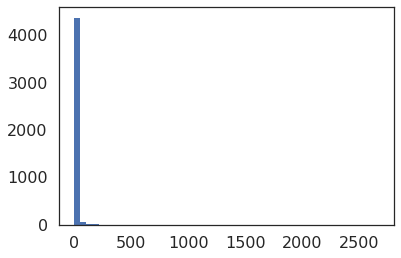

In [463]:
hist(binfeaturenamesplitunicounts[binfeaturenamesplitunicounts>1],bins=50)

In [466]:
binfeaturenamesplit[np.where(binfeaturenamesplit == binfeaturenamesplituni[0])]

array(['Y_RNA_ENSG00000199200.2', 'Y_RNA_ENSG00000199200.2',
       'Y_RNA_ENSG00000199200.2', 'Y_RNA_ENSG00000199200.2',
       'Y_RNA_ENSG00000199200.2', 'Y_RNA_ENSG00000199200.2'], dtype=object)

In [471]:
binfeaturenamesplit.shape

(45746,)

In [519]:
def remove_redundancy(arr,thres=0.95):
    '''
    calculate pcc of a m*n array, find redundancy less than thres
    '''
    pcc = {}
    num = arr.shape[0]
    final = np.arange(0,num)
    for i in range(num-1):
        pcc[i] = []
        for j in range(i+1,num):
            pcc[i].append(pearsonr(arr[i],arr[j])[0])
            if pearsonr(arr[i],arr[j])[0] >thres:
                final = np.setdiff1d(final,np.array([j])) 
    #print (pcc)
    return np.array(final)
    #np.where(pcc)

In [508]:
remove_redundancy(binfeaturesarray[:,np.array([33990,33991 ,33992 ,33993, 33994])].T,0.95)

array([0])

In [ ]:
retainindforbin = []
for i in range(binfeaturenamesplituni.shape[0]):
    unibinind = np.where(binfeaturenamesplit == binfeaturenamesplituni[i])[0]
    if unibinind.shape[0] >1:
        print (unibinind)
    elif unibinind.shape[0] ==1:
        retainindforbin.append(binfeaturenamesplit[unibinind])
        print (unibinind[remove_redundancy(binfeaturesarray[:,unibinind].T,0.95)])
    else:
        print ('something wrong')

In [539]:
retainindforbin = []
for i in tqdm(range(binfeaturenamesplituni.shape[0])):
    unibinind = np.where(binfeaturenamesplit == binfeaturenamesplituni[i])[0]
    if unibinind.shape[0] >1:
        #print (unibinind[remove_redundancy(binfeaturesarray[:,unibinind].T,0.95)])
        retainindforbin.append( unibinind[ remove_redundancy(binfeaturesarray[:,unibinind].T,0.95)])
    elif unibinind.shape[0] ==1:
        retainindforbin.append(unibinind)
        #print (unibinind)
    else:
        print ('something wrong')


 41%|████      | 2434/5950 [03:34<05:10, 11.33it/s]


100%|██████████| 5950/5950 [07:22<00:00, 13.46it/s]

In [540]:
retainindforbin_ = np.array([])
for i in range(len(retainindforbin)):
    retainindforbin_  = np.concatenate((retainindforbin_,retainindforbin[i]))

In [543]:
retainindforbin_.astype('int')

array([ 8118,  8142,  8842, ..., 15044, 15046, 15047])

In [544]:
np.savetxt('binafterremoveredundancy.txt',np.array(retainindforbin_),fmt='%d')

In [545]:
retainindforbin_.shape

(15823,)

In [548]:
retainindforbin_ =retainindforbin_.astype('int')

In [550]:
binfeaturesarray = binfeaturesarray[:,retainindforbin_]

In [552]:
binfeaturenamesplit = binfeaturenamesplit[retainindforbin_]
mixfeaturenamesplit = np.concatenate((fullfeaturename,binfeaturenamesplit)).astype('object')

mixfeaturesarray = np.concatenate((fullfeaturesarray,binfeaturesarray),axis=1)

In [671]:
binfeaturename = binfeaturename[retainindforbin_]
mixfeaturename = np.concatenate((fullfeaturename,binfeaturename)).astype('object')

## 去除了冗余的array!

In [555]:
fullfeaturename.shape,fullfeaturesarray.shape,binfeaturenamesplit.shape,binfeaturesarray.shape,mixfeaturenamesplit.shape,mixfeaturesarray.shape


((10289,), (43, 10289), (15823,), (43, 15823), (26112,), (43, 26112))

### 直接feature selection full fit挑gene！

#### 准备数据供feature selection
- 三种数据格式*(stageA vs control, stageB vs control, stageC vs control, HCC vs control，同时区分三个stage和control)
- 共15种数据
从fullfeaturesarray,binfeaturesarray,mixfeaturesarray加上索引获得
- **目前先做stage A vs normal，HCC vs normal两种**

In [557]:
np.array(usetable['Stage-BCLC'])

array(['A', 'A', 'C', 'A', 'B', 'B', 'B', 'A', 'A', 'B', 'A', 'B', 'A',
       'A', 'B', 'A', 'A', 'C', 'B', 'A', 'B', 'C', 'A', 'B', 'A', 'A',
       'B', 'C', 'A', 'A', '-', '-', '-', '-', '-', '-', '-', '-', '-',
       '-', '-', '-', '-'], dtype=object)

In [558]:
def produce_sample_ind():
    '''
    generate five types of sample ind
    '''
    inda = np.where(usetable['Stage-BCLC'] =='A')[0]
    indb = np.where(usetable['Stage-BCLC'] =='B')[0]
    indc = np.where(usetable['Stage-BCLC'] =='C')[0]
    indnormal = np.where(usetable['Stage-BCLC'] =='-')[0]
    indhcc = np.concatenate((inda,indb,indc))
    return inda,indb,indc,indnormal,indhcc

In [559]:
indA,indB,indC,indnormal,indhcc = produce_sample_ind()

In [560]:
print (indA)
print (indB)
print (indC)
print (indnormal)
print (indhcc)

[ 0  1  3  7  8 10 12 13 15 16 19 22 24 25 28 29]
[ 4  5  6  9 11 14 18 20 23 26]
[ 2 17 21 27]
[30 31 32 33 34 35 36 37 38 39 40 41 42]
[ 0  1  3  7  8 10 12 13 15 16 19 22 24 25 28 29  4  5  6  9 11 14 18 20
 23 26  2 17 21 27]


In [561]:
sampleclass = np.zeros([43]).astype('int') #各种类别的
binaryind = np.zeros([43]).astype('int') #hcc vs normal
binaryind[indhcc] = 1
sampleclass[indA] = 1
sampleclass[indB] = 2
sampleclass[indC] = 3

In [562]:
sampleclass

array([1, 1, 3, 1, 2, 2, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 3, 2, 1, 2, 3,
       1, 2, 1, 1, 2, 3, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [563]:
sampleclass[np.concatenate((indA,indnormal))]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0])

In [564]:
binaryind[np.concatenate((indhcc,indnormal))]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [565]:
def generate_featurearr(featurekind,featureclass):
    '''
    featurekind: full,bin,mix
    featureclass: A,B,C,hcc(hccvsnormal),all(allkinds)
    '''
    stageindAnorm = np.concatenate((indA,indnormal))
    hccnorm = np.concatenate((indhcc,indnormal))
    if featurekind == 'full':
        if featureclass == 'A':
            return fullfeaturesarray[stageindAnorm],sampleclass[stageindAnorm].astype('int')
        elif featureclass == 'hcc':
            return fullfeaturesarray[hccnorm],binaryind[hccnorm].astype('int')
    elif featurekind =='bin':
        if featureclass == 'A':
            return binfeaturesarray[stageindAnorm],sampleclass[stageindAnorm].astype('int')
        elif featureclass == 'hcc':
            return binfeaturesarray[hccnorm],binaryind[hccnorm]  .astype('int')  
    elif featurekind =='mix':
        if featureclass == 'A':
            return mixfeaturesarray[stageindAnorm],sampleclass[stageindAnorm].astype('int')
        elif featureclass == 'hcc':
            return mixfeaturesarray[hccnorm],binaryind[hccnorm].astype('int')

### 先获得六种feature
以full A为例进行尝试

In [566]:
datatype = ['full','bin','mix']
dataclass = ['A','hcc']
dataset = {}
labelset = {} 
for i in range(3):
    dataset[datatype[i]],labelset[datatype[i]] = {},{}
    for j in range(2):
        dataset[datatype[i]][dataclass[j]],labelset[datatype[i]][dataclass[j]] = generate_featurearr(datatype[i],dataclass[j])

In [567]:
dataset['full']['A']
labelset['full']['A']

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0])

In [568]:
labelset

{'bin': {'A': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0]),
  'hcc': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])},
 'full': {'A': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0]),
  'hcc': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])},
 'mix': {'A': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0]),
  'hcc': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])}}

In [569]:
sampleclass

array([1, 1, 3, 1, 2, 2, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 3, 2, 1, 2, 3,
       1, 2, 1, 1, 2, 3, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [570]:
dataset['full']['A'].shape

(29, 10289)

In [571]:
labelset['full']['hcc']

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

### 特征选择
- logistic regression 加上L1正则化，画图显示不同正则化参数选出的feature
- MRMR

In [572]:
def logistic_selection(feature,label,penalty=1):
    logmodel = LogisticRegression(penalty='l1',C=penalty)
    logmodel.fit(feature,label)
    return logmodel.coef_

In [573]:
binfeaturename[i].split('__')

['miRNA_ENSG00000278267.1', '17429', '17436']

In [574]:
def get_featurename(coef,featurename):
    selectfeatureind = np.where(np.abs(coef)>=0.00001)[0]
    #print (np.argsort(-np.abs(coef[selectfeatureind]))[:np.where(coef!=0)[0].shape[0]].shape)
    selectfeatureind_ =selectfeatureind[np.argsort(-np.abs(coef[selectfeatureind]))[:np.where(coef!=0)[0].shape[0]]]
    #print (selectfeatureind_)
    ttttesttab =  pd.DataFrame(np.concatenate((featurename[selectfeatureind_].reshape(-1,1),
                                coef[np.argsort(-np.abs(coef))
                             [:np.where(coef!=0)[0].shape[0]]].reshape(-1,1)),axis=1),
                columns=['ID','importance'])
    countlist_ = []
    #print (ttttesttab.shape)
    num = int(ttttesttab.shape[0]/5)*5
    if num >=50: 
        num =50 
    #print (num)
    for i in range(num):
        countlist_.append(ttttesttab.iloc[i,0]+': '+str(np.round(ttttesttab.iloc[i,1],4)))
    display(pd.DataFrame(np.array(countlist_).reshape(-1,5)))
    fig,ax=plt.subplots(1,figsize=(int(num/5),5))
    ax.plot(np.abs(np.array(ttttesttab.iloc[:,1])))
    ax.set_xticks(np.arange(0,ttttesttab.shape[0],5))
    ax.set_title('feature importance: logistic regression L1')
    return ttttesttab

In [575]:
styles = ["white","dark",'whitegrid',"darkgrid"]
contexts = ['paper','talk','poster','notebook']
sns.set_style(styles[0])
sns.set_context(contexts[2])

In [576]:
dataset['full']['A'].shape

(29, 10289)

In [577]:
labelset['full']['A'].shape

(29,)

In [578]:
logistic_selection(dataset['full']['A'],labelset['full']['A'],penalty=2).shape

(1, 10289)

,0,1,2,3,4
0,miRNA_ENSG00000221586.1: 0.6122,lncRNA_ENSG00000280059.1: 0.4768,piRNA_piR.hsa.21148_60: 0.4271,Y_RNA_ENSG00000202255.1: 0.4232,Y_RNA_ENSG00000201676.1: 0.3222
1,tRNA_36015: 0.3131,lncRNA_ENSG00000256642.1: -0.3112,piRNA_piR.hsa.21148_10: 0.2804,lncRNA_ENSG00000229388.1: -0.2647,tRNA_12975: 0.25
2,lncRNA_ENSG00000259118.5: -0.1939,snoRNA_ENSG00000201025.1: -0.1927,Y_RNA_ENSG00000238783.1: 0.1559,lncRNA_ENSG00000264112.1: 0.1383,snRNA_ENSG00000222724.1: 0.1337
3,lncRNA_ENSG00000268573.1: 0.1294,srpRNA_ENSG00000243420.3: 0.1166,lncRNA_ENSG00000253647.1: 0.1148,lncRNA_ENSG00000258844.1: 0.1063,Y_RNA_ENSG00000201084.1: 0.0954
4,lncRNA_ENSG00000233723.7: 0.0888,snRNA_ENSG00000201386.1: -0.0871,lncRNA_ENSG00000241158.5: -0.0837,lncRNA_ENSG00000255243.1: -0.0823,lncRNA_ENSG00000236485.1: 0.082
5,miRNA_ENSG00000283858.1: 0.0612,lncRNA_ENSG00000249109.1: 0.0557,tRNA_26898: 0.055,lncRNA_ENSG00000274092.1: -0.0488,snoRNA_ENSG00000252337.1: 0.047
6,lncRNA_ENSG00000258944.1: 0.0443,tRNA_28809: 0.035,lncRNA_ENSG00000279043.1: 0.0313,piRNA_piR.hsa.2621_9: 0.031,lncRNA_ENSG00000249628.2: 0.0307
7,piRNA_piR.hsa.2621_50: 0.0297,miRNA_ENSG00000207954.1: 0.0267,lncRNA_ENSG00000254119.5: 0.0233,piRNA_piR.hsa.29477: 0.0194,lncRNA_ENSG00000233424.2: 0.0156


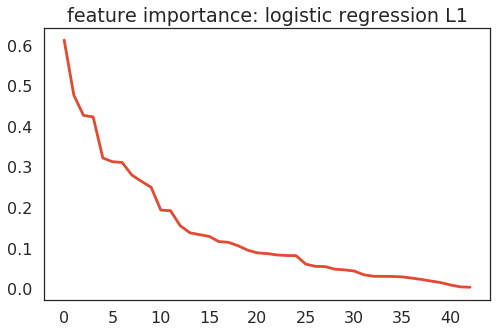

In [579]:
logfullAtable = get_featurename(logistic_selection(dataset['full']['A'],labelset['full']['A'],penalty=2).ravel(),fullfeaturename)

### 1，用logistic regression

Text(0.5,1,'Receiver operating characteristic example')

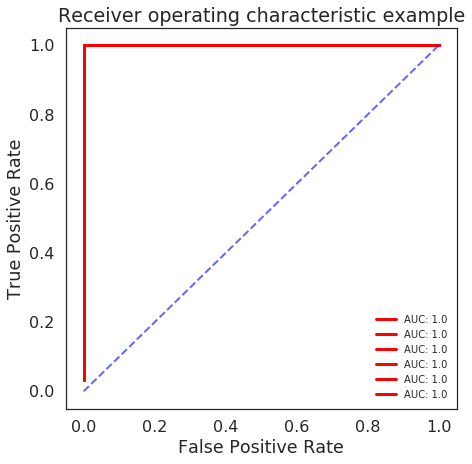

In [580]:
def logistic_roc(feature,label,penalty=2):
    logmodel = LogisticRegression(penalty='l1',C=penalty)
    y_score = logmodel.fit(feature,label).decision_function(feature)
    fpr, tpr, _ = roc_curve(label, y_score)
    roc_auc = auc(fpr, tpr)
    return roc_auc,fpr, tpr,logmodel.predict(feature)
roc,fpr,tpr,predict = {},{},{},{}
for i in range(3):
    for j in range(2):
        roc[i*2+j],fpr[i*2+j],tpr[i*2+j],predict[i*2+j]= \
        logistic_roc(dataset[datatype[i]][dataclass[j]],labelset[datatype[i]][dataclass[j]],penalty=2)
fig,ax=plt.subplots(1,figsize=(7,7))
for i in range(3):
    for j in range(2):
        ax.plot(fpr[i*2+j],tpr[i*2+j],linewidth=3,color='r',label='AUC: '+str(roc[i*2+j]))
ax.legend(prop={'size': 10})
ax.plot([0,1],[0,1], linewidth=2,alpha=0.6,color='b',linestyle='--')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic example')

In [581]:
sampleclass

array([1, 1, 3, 1, 2, 2, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 3, 2, 1, 2, 3,
       1, 2, 1, 1, 2, 3, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [582]:
def soft_max(feature,label,penalty=0.1):
    logmodel = LogisticRegression(penalty='l1',C=penalty,multi_class='multinomial',solver ='saga')
    logmodel.fit(feature,label)
    return logmodel.coef_
tttfeature = soft_max(dataset[datatype[2]][dataclass[1]],sampleclass)
importancettt = tttfeature[np.where(tttfeature !=0)].reshape(-1,1)
testsoft = np.concatenate((dataset[datatype[2]][dataclass[1]][:,np.where(tttfeature[0] !=0)[0]],
     dataset[datatype[2]][dataclass[1]][:,np.where(tttfeature[1] !=0)[0]],
      dataset[datatype[2]][dataclass[1]][:,np.where(tttfeature[2] !=0)[0]],
      dataset[datatype[2]][dataclass[1]][:,np.where(tttfeature[3] !=0)[0]]),axis=1)


In [583]:
samplecolumns = np.ndarray([43,1]).astype('str')
samplecolumns[np.where(sampleclass ==0)] = 'HD'
samplecolumns[np.where(sampleclass ==1)] = 'A'
samplecolumns[np.where(sampleclass ==2)] = 'B'
samplecolumns[np.where(sampleclass ==3)] = 'C'

In [584]:
dataset[datatype[i]][dataclass[j]][:,picked[0:(k+1)]]  ,labelset[datatype[i]][dataclass[j]]

(array([[-3.37614776e-01, -1.55467143e+00, -8.14143783e-01,
          1.13349609e+00, -7.77599734e-01, -1.31478478e+00,
         -5.62195634e-01,  6.52122015e-01,  1.45454201e+00,
          9.91877004e-01, -4.01485990e-01,  2.59698489e-01,
         -8.54383991e-01, -9.54163982e-01,  1.54126372e+00,
         -1.07522054e+00, -5.82518211e-01, -1.13045670e+00,
         -8.68422171e-01, -1.30215308e+00],
        [-3.63397494e-02,  1.05170344e+00,  1.81279123e+00,
         -4.61631967e-01,  1.27936322e-01,  4.38822164e-01,
         -1.90823142e-01, -2.53356739e-01,  7.65434059e-01,
         -6.19776716e-01,  5.88075744e-01,  7.26655137e-01,
          1.05551073e+00,  1.16080073e+00, -3.74730342e-01,
         -1.48784693e-01,  4.39593778e-01,  2.95230562e-01,
          1.99252723e+00,  1.44122278e+00],
        [-3.31716462e-01,  1.93057972e-01,  2.17367118e-01,
          2.45620934e-01,  3.99213272e-01, -9.48907372e-01,
          8.22291953e-01, -3.51460648e-01,  1.00909476e+00,
          2.

In [585]:
dataset[datatype[i]][dataclass[j]][:,picked].shape

(43, 50)

(array([0.19567884, 0.39325411, 0.59082939, 0.78840466, 0.98597993]),
 <a list of 5 Text yticklabel objects>)

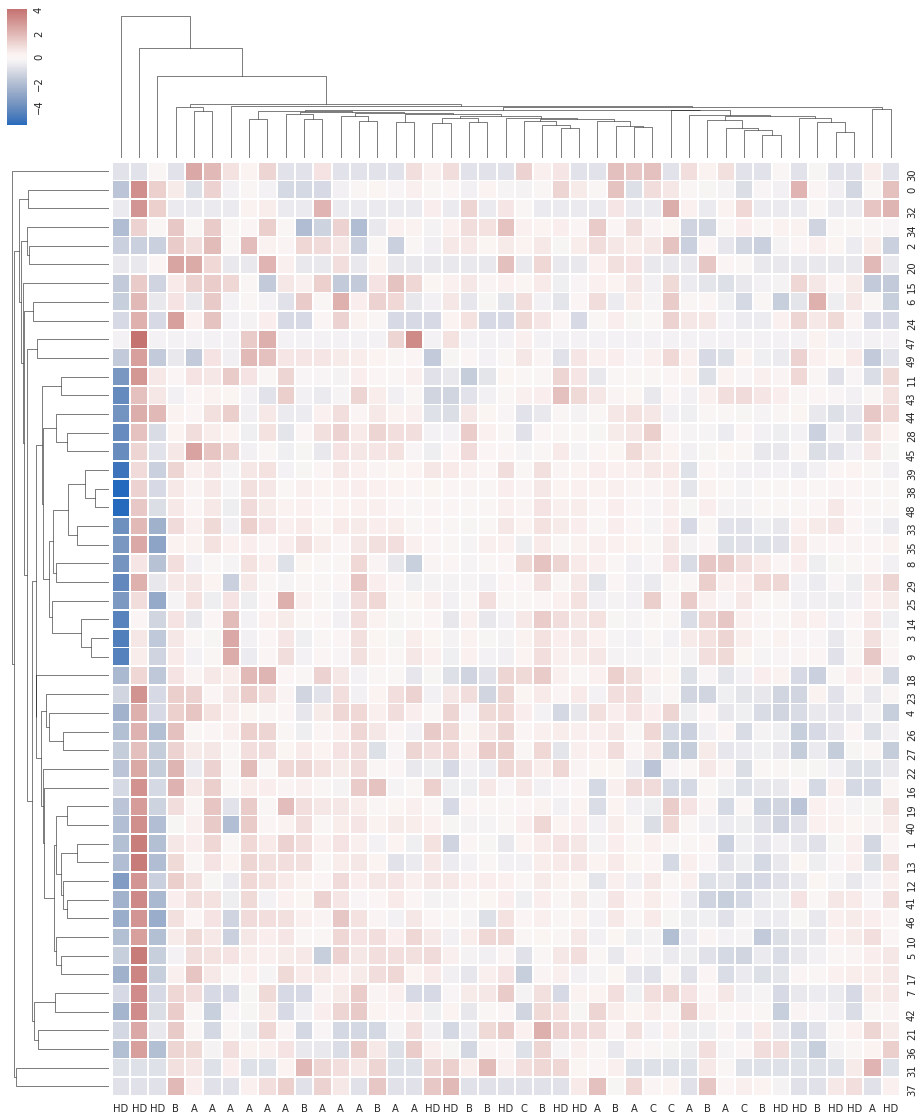

In [586]:
sns.set(font_scale=1)
cg = sns.clustermap(pd.DataFrame(dataset[datatype[i]][dataclass[j]][:,picked].T,
                            columns=samplecolumns.ravel()),
              center=0,cmap="vlag",linewidths=.75, figsize=(16,20)
             )
plt.xticks(rotation=0) 
plt.yticks(rotation='vertical')

In [ ]:
def mrmr_roc(feature,label,penalty=2):
    logmodel = LogisticRegression()
    y_score = logmodel.fit(feature,label).decision_function(feature)
    fpr, tpr, _ = roc_curve(label, y_score)
    roc_auc = auc(fpr, tpr)

In [748]:
mrmrpickind = np.arange(98,196)

In [749]:
roc,fpr,tpr,predict ={},{},{},{}
for k in range(20):
    roc[k],fpr[k],tpr[k],predict[k] ={},{},{},{}
    for i in range(2,3):
        for j in range(1,2):
            roc[k][i*2+j],fpr[k][i*2+j],tpr[k][i*2+j],predict[k][i*2+j]= mrmr_roc(dataset[datatype[i]][dataclass[j]][:,indfrommrmr[i][j][mrmrpickind][np.argsort(-coeffrommrmr[i][j][mrmrpickind])[0:(k+1)]]  ] ,labelset[datatype[i]][dataclass[j]])
            
            

In [750]:
for i in range(20):
    print (roc[i][5])

0.6102564102564102
0.6743589743589745
0.6871794871794872
0.6871794871794872
0.6897435897435897
0.6948717948717948
0.7102564102564103
0.7384615384615385
0.8743589743589744
0.9282051282051282
0.9564102564102563
0.9564102564102563
0.9692307692307693
0.9743589743589742
0.9692307692307693
0.9743589743589742
0.9794871794871794
0.9717948717948717
0.9769230769230768
0.9923076923076923


In [751]:
coeffrommrmr[2][1][mrmrpickind][np.argsort(-coeffrommrmr[2][1][mrmrpickind])]

array([27.076, 18.166, 18.1  , 16.265, 14.297, 13.837, 13.423, 12.878,
       12.877, 12.181, 11.897, 11.886, 11.461, 11.426, 11.054, 11.052,
       11.003, 10.994, 10.98 , 10.927, 10.896, 10.859, 10.681, 10.663,
       10.638, 10.622, 10.603, 10.584, 10.577, 10.564, 10.56 , 10.555,
       10.492, 10.462, 10.4  , 10.373, 10.357, 10.35 , 10.346, 10.313,
       10.239, 10.208, 10.208, 10.202, 10.121, 10.107, 10.103, 10.059,
       10.027,  9.993,  9.879,  9.866,  9.809,  9.787,  9.782,  9.772,
        9.763,  9.76 ,  9.724,  9.716,  9.697,  9.692,  9.691,  9.682,
        9.68 ,  9.678,  9.675,  9.659,  9.658,  9.649,  9.64 ,  9.623,
        9.621,  9.621,  9.619,  9.616,  9.613,  9.613,  9.604,  9.591,
        9.57 ,  9.531,  9.503,  9.485,  9.47 ,  9.445,  9.434,  9.425,
        9.419,  9.369,  9.366,  9.353,  9.352,  9.35 ,  9.346,  9.327,
        9.316,  9.292])

In [756]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [766]:
np.array([roc[i][5] for i in range(10)])

array([0.61025641, 0.67435897, 0.68717949, 0.68717949, 0.68974359,
       0.69487179, 0.71025641, 0.73846154, 0.87435897, 0.92820513])

In [783]:
styles = ["white","dark",'whitegrid',"darkgrid"]
contexts = ['paper','talk','poster','notebook']
sns.set_style(styles[0])
sns.set_context(contexts[0])

Text(0,0.5,'AUC')

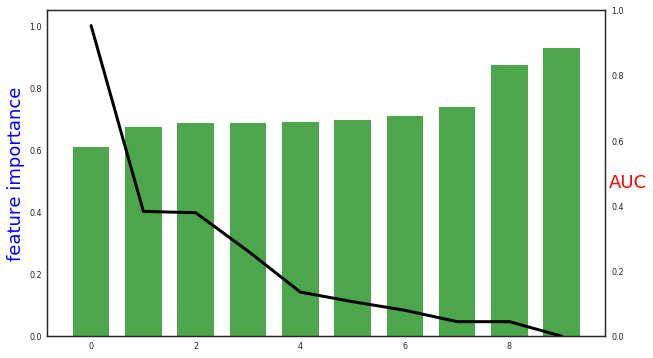

In [787]:
fig,ax=plt.subplots(1,figsize=(10,6))
ax.plot(scaler.fit_transform(coeffrommrmr[2][1][mrmrpickind][np.argsort(-coeffrommrmr[2][1][mrmrpickind])][:10].reshape(-1,1)).ravel(),
       color='black',linewidth=3.0)
ax.set_ylabel('feature importance', color='b',fontsize=18)
ax2 = ax.twinx()
ax.bar(range(10),np.array([roc[i][5] for i in range(10)]),0.7,color='g',alpha=0.7)
ax2.set_ylabel('AUC', color='r',rotation=0,fontsize=18)

In [790]:
np.array([roc[i][5] for i in range(11)])[1:] - np.array([roc[i][5] for i in range(10)])

array([0.06410256, 0.01282051, 0.        , 0.0025641 , 0.00512821,
       0.01538462, 0.02820513, 0.13589744, 0.05384615, 0.02820513])

Text(0,0.5,'AUC improvement')

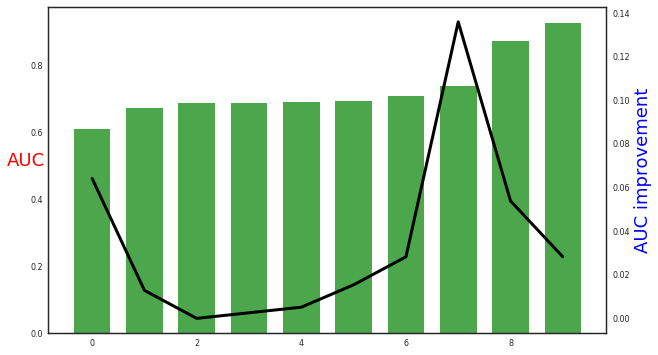

In [793]:
fig,ax=plt.subplots(1,figsize=(10,6))
ax.bar(range(10),np.array([roc[i][5] for i in range(10)]),0.7,color='g',alpha=0.7)
ax.set_ylabel('AUC', color='r',rotation=0,fontsize=18)
ax2 = ax.twinx()
ax2.plot(np.array([roc[i][5] for i in range(11)])[1:] - np.array([roc[i][5] for i in range(10)]),
       color='black',linewidth=3.0)
ax2.set_ylabel('AUC improvement', color='b',fontsize=18)



Text(0,0.5,'AUC improvement')

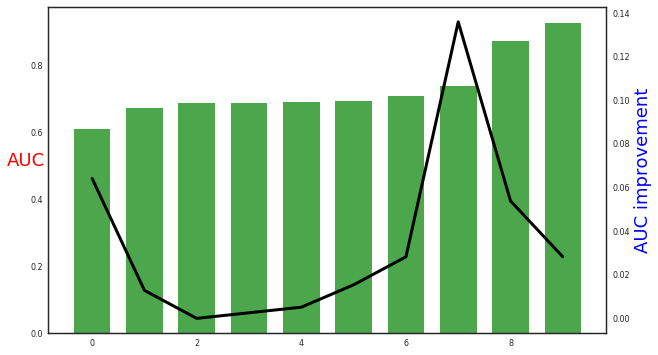

In [793]:
fig,ax=plt.subplots(1,figsize=(10,6))
ax.bar(range(10),np.array([roc[i][5] for i in range(10)]),0.7,color='g',alpha=0.7)
ax.set_ylabel('AUC', color='r',rotation=0,fontsize=18)
ax2 = ax.twinx()
ax2.plot(np.array([roc[i][5] for i in range(11)])[1:] - np.array([roc[i][5] for i in range(10)]),
       color='black',linewidth=3.0)
ax2.set_ylabel('AUC improvement', color='b',fontsize=18)



In [ ]:
#forward and RFE

forward:每次找最高的，然后选出来  另用一个range来保证取的feature总是在总index
    

In [812]:
roc,fpr,tpr,predict ={},{},{},{}
for k in range(20):
    roc[k],fpr[k],tpr[k],predict[k] ={},{},{},{}
    for i in range(0,1):
        for j in range(1,2):
            roc[k][i*2+j],fpr[k][i*2+j],tpr[k][i*2+j],predict[k][i*2+j]= mrmr_roc(dataset[datatype[i]][dataclass[j]][:, rfe.ranking_[0:(k+1)] ] ,labelset[datatype[i]][dataclass[j]])
            
    

Text(0,0.5,'AUC improvement')

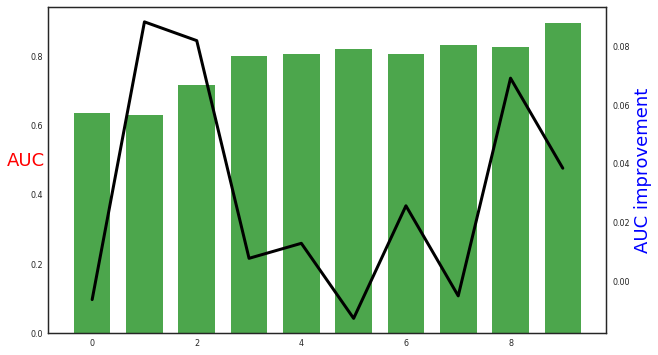

In [815]:
fig,ax=plt.subplots(1,figsize=(10,6))
ax.bar(range(10),np.array([roc[i][1] for i in range(10)]),0.7,color='g',alpha=0.7)
ax.set_ylabel('AUC', color='r',rotation=0,fontsize=18)
ax2 = ax.twinx()
ax2.plot(np.array([roc[i][1] for i in range(11)])[1:] - np.array([roc[i][1] for i in range(10)]),
       color='black',linewidth=3.0)
ax2.set_ylabel('AUC improvement', color='b',fontsize=18)



In [589]:
def logistic_selection_(feature,label,penalty=1):
    logmodel = LogisticRegression(penalty='l1',C=penalty)
    logmodel.fit(feature,label)
    return logmodel.coef_

In [590]:
def logistic_selection(feature,label):
    logmodel = LogisticRegression()
    logmodel.fit(feature,label)
    return logmodel.coef_

In [591]:
np.argsort(logistic_selection(dataset['full']['A'],labelset['full']['A']))

array([[3233, 4412, 9429, ..., 5673, 1925, 8026]])

In [592]:
np.sort(logistic_selection(dataset['full']['A'],labelset['full']['A']))

array([[-0.01425186, -0.01357237, -0.01325521, ...,  0.01416681,
         0.01491083,  0.01568766]])

In [ ]:
ranking = rfe.ranking_.reshape(digits.images[0].shape)

# Plot pixel ranking
plt.matshow(ranking, cmap=plt.cm.Blues)
plt.colorbar()
plt.title("Ranking of pixels with RFE")
plt.show()

In [740]:
def RFE_logistic(feature,label,step=100,threshold=50):
    featureind = np.array([]) # each loop delete feature ind
    featurenum = feature.shape[1]
    originalfeatureind = np.arange(0,featurenum)
    countnum = 0  #count loop
    while featurenum - step*countnum > threshold:
        print (countnum)
        #print (featurenum , step*countnum , threshold)
        deleteind = np.argsort(np.abs(logistic_selection(feature[:,originalfeatureind],label))).ravel()[:step]
        originalfeatureind = np.setdiff1d(originalfeatureind,deleteind)
        print (originalfeatureind.shape ,featureind.shape,deleteind.shape)
        featureind = np.concatenate((featureind,deleteind))
        countnum +=1
        #print (featurenum , step*countnum , threshold)
    return originalfeatureind,featureind
originalfeatureind,featureind = RFE_logistic(dataset['full']['A'],labelset['full']['A'],step=100,threshold=50)

0
(10189,) (0,) (100,)
1
(10090,) (100,) (100,)
2
(9993,) (200,) (100,)
3
(9896,) (300,) (100,)
4
(9802,) (400,) (100,)
5
(9707,) (500,) (100,)
6
(9615,) (600,) (100,)
7
(9521,) (700,) (100,)
8
(9430,) (800,) (100,)
9
(9338,) (900,) (100,)
10
(9248,) (1000,) (100,)
11
(9159,) (1100,) (100,)
12
(9074,) (1200,) (100,)
13
(8989,) (1300,) (100,)
14
(8905,) (1400,) (100,)
15
(8820,) (1500,) (100,)
16
(8736,) (1600,) (100,)
17
(8654,) (1700,) (100,)
18
(8573,) (1800,) (100,)
19
(8488,) (1900,) (100,)
20
(8399,) (2000,) (100,)
21
(8325,) (2100,) (100,)
22
(8247,) (2200,) (100,)
23
(8171,) (2300,) (100,)
24
(8096,) (2400,) (100,)
25
(8019,) (2500,) (100,)
26
(7945,) (2600,) (100,)
27
(7869,) (2700,) (100,)
28
(7796,) (2800,) (100,)
29
(7722,) (2900,) (100,)
30
(7652,) (3000,) (100,)
31
(7572,) (3100,) (100,)
32
(7502,) (3200,) (100,)
33
(7435,) (3300,) (100,)
34
(7364,) (3400,) (100,)
35
(7309,) (3500,) (100,)
36
(7233,) (3600,) (100,)
37
(7168,) (3700,) (100,)
38
(7114,) (3800,) (100,)
39
(70

In [741]:
def logistic_roc(feature,label):
    logmodel = LogisticRegression()
    y_score = logmodel.fit(feature,label).decision_function(feature)
    fpr, tpr, _ = roc_curve(label, y_score)
    roc_auc = auc(fpr, tpr)
    return np.array([roc_auc]), fpr, tpr
roc,fpr,tpr ={},{},{}
for k in range(20):
    roc[k],fpr[k],tpr[k] ={},{},{}
    for i in range(0,1):
        for j in range(0,1):
            roc[k][i*2+j],fpr[k][i*2+j],tpr[k][i*2+j]=\
            logistic_roc(dataset[datatype[i]][dataclass[j]][:,np.flip(featureind.astype('int')[-20:],axis=0)][:,0:(k+1)]  ,labelset[datatype[i]][dataclass[j]])
            

In [742]:
styles = ["white","dark",'whitegrid',"darkgrid"]
contexts = ['paper','talk','poster','notebook']
sns.set_style(styles[0])
sns.set_context(contexts[2])

Text(0,0.5,'AUC improvement')

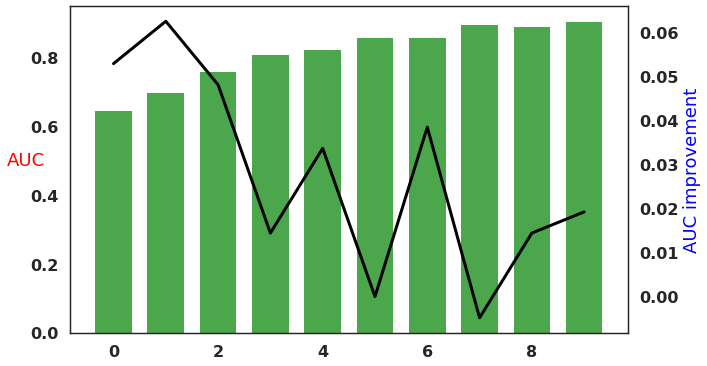

In [743]:
fig,ax=plt.subplots(1,figsize=(10,6))
ax.bar(range(10),np.array([roc[i][0] for i in range(10)]).ravel(),0.7,color='g',alpha=0.7)
ax.set_ylabel('AUC', color='r',rotation=0,fontsize=18)
ax2 = ax.twinx()
ax2.plot(np.array([roc[i][0] for i in range(11)])[1:] - np.array([roc[i][0] for i in range(10)]),
       color='black',linewidth=3.0)
ax2.set_ylabel('AUC improvement', color='b',fontsize=18)


In [744]:
from tqdm import tqdm

In [745]:
def forward_selection(feature,label,step=1,threshold=10):
    featureind = np.array([]) # each loop delete feature ind
    featurenum = feature.shape[1]
    countnum = 0  #count loop
    originalfeatureind = np.arange(0,featurenum)
    picked = np.array([])
    while countnum < threshold:
        print (countnum)
        auc = np.zeros([featurenum])
        remain = np.setdiff1d(originalfeatureind,picked)
        for i in tqdm(remain):
            #print ( logistic_roc(feature[:,np.concatenate((featureind,np.array([i]))).astype('int')],label)[0])
            auc[i] = logistic_roc(feature[:,np.concatenate((picked,np.array([i]))).astype('int')],label)[0]
        print (auc)
        pickfeatureind = originalfeatureind[np.argmax(auc)]
        #print (pickfeatureind)
        #originalfeatureind = np.setdiff1d(originalfeatureind,pickfeatureind)
        #print (pickfeatureind)
        picked = np.concatenate((picked,np.array([pickfeatureind])))
        #print (picked)
        countnum += 1
    return picked.astype('int')

In [746]:
np.argmax(np.array([1,1,1]))

0

In [747]:
picked = forward_selection(dataset[datatype[2]][dataclass[1]][:,np.flip(featureind.astype('int')[-50:],axis=0)] ,
                           labelset['mix']['hcc'],step=1,threshold=50)


  0%|          | 0/44 [00:00<?, ?it/s]

0
[0.52307692 0.55384615 0.56410256 0.67692308 0.58589744 0.61794872
 0.6        0.51282051 0.52307692 0.53846154 0.61025641 0.64615385
 0.61538462 0.64358974 0.58076923 0.60769231 0.73076923 0.54487179
 0.57435897 0.64615385 0.61282051 0.57435897 0.66410256 0.65897436
 0.58205128 0.56410256 0.60512821 0.58076923 0.61794872 0.46794872
 0.51794872 0.74615385 0.62820513 0.46666667 0.71794872 0.61025641
 0.73846154 0.52564103 0.60512821 0.59487179 0.71538462 0.71025641
 0.57435897 0.51153846 0.62051282 0.54102564 0.65384615 0.64102564
 0.73589744 0.55897436]
1
[0.77564103 0.72692308 0.8025641  0.86666667 0.77307692 0.84102564
 0.79487179 0.73333333 0.78846154 0.74230769 0.74871795 0.82051282
 0.73589744 0.85128205 0.73333333 0.79102564 0.86666667 0.76923077
 0.81025641 0.84358974 0.77692308 0.81794872 0.81025641 0.83076923
 0.78205128 0.77948718 0.81025641 0.79230769 0.81794872 0.77179487
 0.76153846 0.         0.7974359  0.74358974 0.86153846 0.82051282
 0.87179487 0.78205128 0.7974359  


  0%|          | 0/37 [00:00<?, ?it/s]


[0.97692308 0.         0.98205128 0.97435897 0.         0.97692308
 0.97948718 0.96923077 0.98974359 0.96923077 0.97948718 0.97179487
 0.98461538 0.97948718 0.97179487 0.96923077 0.96923077 0.97179487
 0.98717949 0.96666667 0.97692308 0.97692308 0.98205128 0.97435897
 0.98205128 0.         0.98205128 0.98461538 0.96923077 0.98205128
 0.         0.         0.97179487 0.97692308 0.97948718 0.97179487
 0.97435897 0.97435897 0.97435897 0.97692308 0.97179487 0.97179487
 0.97692308 0.97692308 0.97948718 0.97435897 0.97692308 0.97692308
 0.         0.98205128]
7
[0.97692308 0.         0.98461538 0.97692308 0.         0.97948718
 0.98205128 0.97435897 0.         0.97435897 0.98461538 0.97948718
 0.98717949 0.97948718 0.97179487 0.97435897 0.97692308 0.97179487
 0.98461538 0.96923077 0.97692308 0.97948718 0.98205128 0.97692308
 0.98205128 0.         0.98205128 0.98461538 0.97179487 0.97948718
 0.         0.         0.97435897 0.98205128 0.97948718 0.97692308
 0.97435897 0.98461538 0.97435897 0.

  0%|          | 0/28 [00:00<?, ?it/s]

[0.         0.         0.         0.         0.         1.
 1.         1.         0.         1.         1.         1.
 0.         1.         0.         0.9974359  1.         0.99487179
 1.         0.9974359  1.         1.         1.         1.
 1.         0.         1.         0.99487179 1.         1.
 0.         0.         1.         1.         0.         0.9974359
 0.99230769 1.         1.         1.         0.9974359  0.99487179
 1.         1.         1.         1.         1.         1.
 0.         1.        ]
14
[0.         0.         0.         0.         0.         0.
 1.         1.         0.         1.         1.         1.
 0.         1.         0.         0.9974359  1.         0.9974359
 1.         1.         1.         1.         1.         1.
 1.         0.         1.         0.99487179 1.         1.
 0.         0.         1.         1.         0.         1.
 0.99230769 1.         1.         1.         0.9974359  0.99487179
 1.         1.         1.         1.         1.   


  0%|          | 0/16 [00:00<?, ?it/s]

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1.
 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 1.]
23
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1.
 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 1.]
24
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1.
 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 1.]
25
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.
 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 1.]
26
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.
 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 1.]
27
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.
 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 1.]
28
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 


100%|██████████| 1/1 [00:00<00:00, 875.27it/s]

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 1.]
35
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 1.]
36
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 1.]
37
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 1.]
38
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 1.]
39
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 1.]
40
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

In [748]:
picked

array([31, 48, 30, 25,  1,  4,  8, 12, 34, 14,  0,  2,  3,  5,  6,  7,  9,
       10, 11, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29,
       32, 33, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 49])

In [749]:
roc,fpr,tpr ={},{},{}
for k in range(20):
    roc[k],fpr[k],tpr[k] ={},{},{}
    for i in range(2,3):
        for j in range(1,2):
            roc[k][i*2+j],fpr[k][i*2+j],tpr[k][i*2+j]=\
            logistic_roc(dataset[datatype[i]][dataclass[j]][:,picked[0:(k+1)]]  ,labelset[datatype[i]][dataclass[j]])

Text(0,0.5,'AUC')

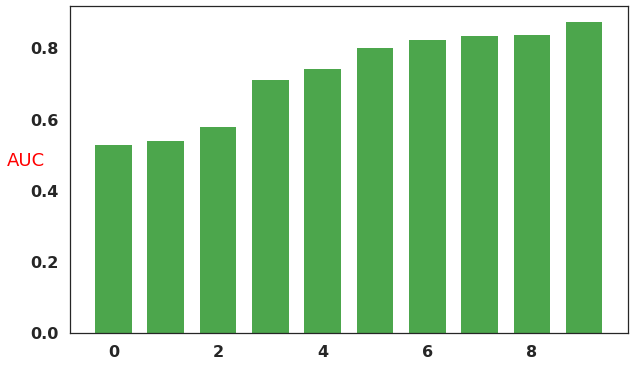

In [750]:
fig,ax=plt.subplots(1,figsize=(10,6))
ax.bar(range(10),np.array([roc[i][5] for i in range(10)]).ravel(),0.7,color='g',alpha=0.7)
ax.set_ylabel('AUC', color='r',rotation=0,fontsize=18)
#ax2 = ax.twinx()
#ax2.plot(np.array([roc[i][5] for i in range(11)])[1:] - np.array([roc[i][5] for i in range(10)]),
 #      color='black',linewidth=3.0)
#ax2.set_ylabel('AUC improvement', color='b',fontsize=18)


# 7.28 工作
- AUC improvement, feature importance, cluster, 交集与并集
- 对于HCC vs normal，stageA vs Normal两组label
- 在三种feature上各自做RFE和forward！

- 挑出来的feature分别
    - 画AUC
    - feature importance
    - clsutering
- 然后比较挑出来的feature的交集和并集，尤其是bin和full的交集！

In [751]:
for i in range(3):
    for j in range(2):
        print (datatype[i],dataclass[j])

full A
full hcc
bin A
bin hcc
mix A
mix hcc


In [752]:
def RFE_logistic(feature,label,step=100,threshold=50):
    featureind = np.array([]) # each loop delete feature ind
    featurenum = feature.shape[1]
    originalfeatureind = np.arange(0,featurenum)
    countnum = 0  #count loop
    while featurenum - step*countnum > threshold:
        print (countnum)
        #print (featurenum , step*countnum , threshold)
        deleteind = originalfeatureind[np.argsort(logistic_selection(feature[:,originalfeatureind],label)).ravel()[:step]]
        originalfeatureind = np.setdiff1d(originalfeatureind,deleteind)
        print (originalfeatureind.shape ,featureind.shape,deleteind.shape)
        featureind = np.concatenate((featureind,deleteind))
        countnum +=1
        #print (featurenum , step*countnum , threshold)
    return featureind

In [753]:
#需要倒着提取
rfefeatureind = {}
for i in tqdm(range(3)):
    rfefeatureind[i] = {}
    for j in tqdm(range(2)):
        rfefeatureind[i][j] = RFE_logistic(dataset[datatype[i]][dataclass[j]],labelset[datatype[i]][dataclass[j]],step=100,threshold=50)


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

0
(10189,) (0,) (100,)
1
(10089,) (100,) (100,)
2
(9989,) (200,) (100,)
3
(9889,) (300,) (100,)
4
(9789,) (400,) (100,)
5
(9689,) (500,) (100,)
6
(9589,) (600,) (100,)
7
(9489,) (700,) (100,)
8
(9389,) (800,) (100,)
9
(9289,) (900,) (100,)
10
(9189,) (1000,) (100,)
11
(9089,) (1100,) (100,)
12
(8989,) (1200,) (100,)
13
(8889,) (1300,) (100,)
14
(8789,) (1400,) (100,)
15
(8689,) (1500,) (100,)
16
(8589,) (1600,) (100,)
17
(8489,) (1700,) (100,)
18
(8389,) (1800,) (100,)
19
(8289,) (1900,) (100,)
20
(8189,) (2000,) (100,)
21
(8089,) (2100,) (100,)
22
(7989,) (2200,) (100,)
23
(7889,) (2300,) (100,)
24
(7789,) (2400,) (100,)
25
(7689,) (2500,) (100,)
26
(7589,) (2600,) (100,)
27
(7489,) (2700,) (100,)
28
(7389,) (2800,) (100,)
29
(7289,) (2900,) (100,)
30
(7189,) (3000,) (100,)
31
(7089,) (3100,) (100,)
32
(6989,) (3200,) (100,)
33
(6889,) (3300,) (100,)
34
(6789,) (3400,) (100,)
35
(6689,) (3500,) (100,)
36
(6589,) (3600,) (100,)
37
(6489,) (3700,) (100,)
38
(6389,) (3800,) (100,)
39
(62



 50%|█████     | 1/2 [00:01<00:01,  1.96s/it]

(1489,) (8700,) (100,)
88
(1389,) (8800,) (100,)
89
(1289,) (8900,) (100,)
90
(1189,) (9000,) (100,)
91
(1089,) (9100,) (100,)
92
(989,) (9200,) (100,)
93
(889,) (9300,) (100,)
94
(789,) (9400,) (100,)
95
(689,) (9500,) (100,)
96
(589,) (9600,) (100,)
97
(489,) (9700,) (100,)
98
(389,) (9800,) (100,)
99
(289,) (9900,) (100,)
100
(189,) (10000,) (100,)
101
(89,) (10100,) (100,)
102
(0,) (10200,) (89,)
0
(10189,) (0,) (100,)
1
(10089,) (100,) (100,)
2
(9989,) (200,) (100,)
3
(9889,) (300,) (100,)
4
(9789,) (400,) (100,)
5
(9689,) (500,) (100,)
6
(9589,) (600,) (100,)
7
(9489,) (700,) (100,)
8
(9389,) (800,) (100,)
9
(9289,) (900,) (100,)
10
(9189,) (1000,) (100,)
11
(9089,) (1100,) (100,)
12
(8989,) (1200,) (100,)
13
(8889,) (1300,) (100,)
14
(8789,) (1400,) (100,)
15
(8689,) (1500,) (100,)
16
(8589,) (1600,) (100,)
17
(8489,) (1700,) (100,)
18
(8389,) (1800,) (100,)
19
(8289,) (1900,) (100,)
20
(8189,) (2000,) (100,)
21
(8089,) (2100,) (100,)
22
(7989,) (2200,) (100,)
23
(7889,) (2300,)



100%|██████████| 2/2 [00:05<00:00,  2.54s/it]


 33%|███▎      | 1/3 [00:05<00:10,  5.08s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

(2289,) (7900,) (100,)
80
(2189,) (8000,) (100,)
81
(2089,) (8100,) (100,)
82
(1989,) (8200,) (100,)
83
(1889,) (8300,) (100,)
84
(1789,) (8400,) (100,)
85
(1689,) (8500,) (100,)
86
(1589,) (8600,) (100,)
87
(1489,) (8700,) (100,)
88
(1389,) (8800,) (100,)
89
(1289,) (8900,) (100,)
90
(1189,) (9000,) (100,)
91
(1089,) (9100,) (100,)
92
(989,) (9200,) (100,)
93
(889,) (9300,) (100,)
94
(789,) (9400,) (100,)
95
(689,) (9500,) (100,)
96
(589,) (9600,) (100,)
97
(489,) (9700,) (100,)
98
(389,) (9800,) (100,)
99
(289,) (9900,) (100,)
100
(189,) (10000,) (100,)
101
(89,) (10100,) (100,)
102
(0,) (10200,) (89,)
0
(15723,) (0,) (100,)
1
(15623,) (100,) (100,)
2
(15523,) (200,) (100,)
3
(15423,) (300,) (100,)
4
(15323,) (400,) (100,)
5
(15223,) (500,) (100,)
6
(15123,) (600,) (100,)
7
(15023,) (700,) (100,)
8
(14923,) (800,) (100,)
9
(14823,) (900,) (100,)
10
(14723,) (1000,) (100,)
11
(14623,) (1100,) (100,)
12
(14523,) (1200,) (100,)
13
(14423,) (1300,) (100,)
14
(14323,) (1400,) (100,)
15
(1



 50%|█████     | 1/2 [00:05<00:05,  5.06s/it]

(1923,) (13800,) (100,)
139
(1823,) (13900,) (100,)
140
(1723,) (14000,) (100,)
141
(1623,) (14100,) (100,)
142
(1523,) (14200,) (100,)
143
(1423,) (14300,) (100,)
144
(1323,) (14400,) (100,)
145
(1223,) (14500,) (100,)
146
(1123,) (14600,) (100,)
147
(1023,) (14700,) (100,)
148
(923,) (14800,) (100,)
149
(823,) (14900,) (100,)
150
(723,) (15000,) (100,)
151
(623,) (15100,) (100,)
152
(523,) (15200,) (100,)
153
(423,) (15300,) (100,)
154
(323,) (15400,) (100,)
155
(223,) (15500,) (100,)
156
(123,) (15600,) (100,)
157
(23,) (15700,) (100,)
0
(15723,) (0,) (100,)
1
(15623,) (100,) (100,)
2
(15523,) (200,) (100,)
3
(15423,) (300,) (100,)
4
(15323,) (400,) (100,)
5
(15223,) (500,) (100,)
6
(15123,) (600,) (100,)
7
(15023,) (700,) (100,)
8
(14923,) (800,) (100,)
9
(14823,) (900,) (100,)
10
(14723,) (1000,) (100,)
11
(14623,) (1100,) (100,)
12
(14523,) (1200,) (100,)
13
(14423,) (1300,) (100,)
14
(14323,) (1400,) (100,)
15
(14223,) (1500,) (100,)
16
(14123,) (1600,) (100,)
17
(14023,) (1700,



100%|██████████| 2/2 [00:13<00:00,  6.77s/it]


 67%|██████▋   | 2/3 [00:18<00:09,  9.31s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

(2523,) (13200,) (100,)
133
(2423,) (13300,) (100,)
134
(2323,) (13400,) (100,)
135
(2223,) (13500,) (100,)
136
(2123,) (13600,) (100,)
137
(2023,) (13700,) (100,)
138
(1923,) (13800,) (100,)
139
(1823,) (13900,) (100,)
140
(1723,) (14000,) (100,)
141
(1623,) (14100,) (100,)
142
(1523,) (14200,) (100,)
143
(1423,) (14300,) (100,)
144
(1323,) (14400,) (100,)
145
(1223,) (14500,) (100,)
146
(1123,) (14600,) (100,)
147
(1023,) (14700,) (100,)
148
(923,) (14800,) (100,)
149
(823,) (14900,) (100,)
150
(723,) (15000,) (100,)
151
(623,) (15100,) (100,)
152
(523,) (15200,) (100,)
153
(423,) (15300,) (100,)
154
(323,) (15400,) (100,)
155
(223,) (15500,) (100,)
156
(123,) (15600,) (100,)
157
(23,) (15700,) (100,)
0
(26012,) (0,) (100,)
1
(25912,) (100,) (100,)
2
(25812,) (200,) (100,)
3
(25712,) (300,) (100,)
4
(25612,) (400,) (100,)
5
(25512,) (500,) (100,)
6
(25412,) (600,) (100,)
7
(25312,) (700,) (100,)
8
(25212,) (800,) (100,)
9
(25112,) (900,) (100,)
10
(25012,) (1000,) (100,)
11
(24912,) 



 50%|█████     | 1/2 [00:13<00:13, 13.64s/it]

(2712,) (23300,) (100,)
234
(2612,) (23400,) (100,)
235
(2512,) (23500,) (100,)
236
(2412,) (23600,) (100,)
237
(2312,) (23700,) (100,)
238
(2212,) (23800,) (100,)
239
(2112,) (23900,) (100,)
240
(2012,) (24000,) (100,)
241
(1912,) (24100,) (100,)
242
(1812,) (24200,) (100,)
243
(1712,) (24300,) (100,)
244
(1612,) (24400,) (100,)
245
(1512,) (24500,) (100,)
246
(1412,) (24600,) (100,)
247
(1312,) (24700,) (100,)
248
(1212,) (24800,) (100,)
249
(1112,) (24900,) (100,)
250
(1012,) (25000,) (100,)
251
(912,) (25100,) (100,)
252
(812,) (25200,) (100,)
253
(712,) (25300,) (100,)
254
(612,) (25400,) (100,)
255
(512,) (25500,) (100,)
256
(412,) (25600,) (100,)
257
(312,) (25700,) (100,)
258
(212,) (25800,) (100,)
259
(112,) (25900,) (100,)
260
(12,) (26000,) (100,)
0
(26012,) (0,) (100,)
1
(25912,) (100,) (100,)
2
(25812,) (200,) (100,)
3
(25712,) (300,) (100,)
4
(25612,) (400,) (100,)
5
(25512,) (500,) (100,)
6
(25412,) (600,) (100,)
7
(25312,) (700,) (100,)
8
(25212,) (800,) (100,)
9
(25112



100%|██████████| 2/2 [00:37<00:00, 19.00s/it]


100%|██████████| 3/3 [00:56<00:00, 18.88s/it]


(12,) (26000,) (100,)


In [754]:
for i in tqdm(range(3)):
    for j in tqdm(range(2)):
        np.savetxt('output/rfe/'+datatype[i]+dataclass[j],rfefeatureind[i][j],fmt='%d')


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 36.72it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00, 16.14it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 14.29it/s]

In [755]:
rfefeatureind[i][j]

array([21804., 16369., 24268., ...,   190., 24004., 23867.])

In [756]:
def forward_selection(feature,label,step=1,threshold=10):
    featureind = np.array([]) # each loop delete feature ind
    featurenum = feature.shape[1]
    countnum = 0  #count loop
    originalfeatureind = np.arange(0,featurenum)
    picked = np.array([])
    while countnum < threshold:
        #print (countnum)
        auc = np.zeros([featurenum])
        remain = np.setdiff1d(originalfeatureind,picked)
        for i in tqdm(remain):
            #print ( logistic_roc(feature[:,np.concatenate((featureind,np.array([i]))).astype('int')],label)[0])
            auc[i] = logistic_roc(feature[:,np.concatenate((picked,np.array([i]))).astype('int')],label)[0]
        #print (auc)
        pickfeatureind = originalfeatureind[np.argmax(auc)]
        #print (pickfeatureind)
        #originalfeatureind = np.setdiff1d(originalfeatureind,pickfeatureind)
        #print (pickfeatureind)
        picked = np.concatenate((picked,np.array([pickfeatureind])))
        #print (picked)
        countnum += 1
    return picked.astype('int')

In [757]:
#需要倒着提取
pickedind = {}
for i in tqdm(range(3)):
    pickedind[i] = {}
    for j in tqdm(range(2)):
        pickedind[i][j] = forward_selection(dataset[datatype[i]][dataclass[j]][:,np.flip(rfefeatureind[i][j].astype('int')[-50:],axis=0)],labelset[datatype[i]][dataclass[j]],step=1,threshold=50)


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]


  0%|          | 0/50 [00:00<?, ?it/s]


100%|██████████| 50/50 [00:00<00:00, 1366.76it/s]


  0%|          | 0/49 [00:00<?, ?it/s]


100%|██████████| 49/49 [00:00<00:00, 1490.24it/s]


  0%|          | 0/48 [00:00<?, ?it/s]


100%|██████████| 48/48 [00:00<00:00, 1578.73it/s]


  0%|          | 0/47 [00:00<?, ?it/s]


100%|██████████| 47/47 [00:00<00:00, 1704.57it/s]


  0%|          | 0/46 [00:00<?, ?it/s]


100%|██████████| 46/46 [00:00<00:00, 1686.98it/s]


  0%|          | 0/45 [00:00<?, ?it/s]


100%|██████████| 45/45 [00:00<00:00, 1692.46it/s]


  0%|          | 0/44 [00:00<?, ?it/s]


100%|██████████| 44/44 [00:00<00:00, 1662.13it/s]


  0%|          | 0/43 [00:00<?, ?it/s]


100%|██████████| 43/43 [00:00<00:00, 1675.23it/s]


  0%|          | 0/42 [00:00<?, ?it/s]


100%|██████████| 42/42 [00:00<00:00, 1730.27it/s]


  0%|          | 0/41 [00:00<?, ?it/s]


100%|██████████| 41/41 [00:00<00:00, 1612.

100%|██████████| 28/28 [00:00<00:00, 1613.68it/s]


  0%|          | 0/27 [00:00<?, ?it/s]


100%|██████████| 27/27 [00:00<00:00, 1608.18it/s]


  0%|          | 0/26 [00:00<?, ?it/s]


100%|██████████| 26/26 [00:00<00:00, 1592.60it/s]


  0%|          | 0/25 [00:00<?, ?it/s]


100%|██████████| 25/25 [00:00<00:00, 1576.05it/s]


  0%|          | 0/24 [00:00<?, ?it/s]


100%|██████████| 24/24 [00:00<00:00, 1572.10it/s]


  0%|          | 0/23 [00:00<?, ?it/s]


100%|██████████| 23/23 [00:00<00:00, 1559.37it/s]


  0%|          | 0/22 [00:00<?, ?it/s]


100%|██████████| 22/22 [00:00<00:00, 1565.33it/s]


  0%|          | 0/21 [00:00<?, ?it/s]


100%|██████████| 21/21 [00:00<00:00, 1534.02it/s]


  0%|          | 0/20 [00:00<?, ?it/s]


100%|██████████| 20/20 [00:00<00:00, 1536.99it/s]


  0%|          | 0/19 [00:00<?, ?it/s]


100%|██████████| 19/19 [00:00<00:00, 1511.20it/s]


  0%|          | 0/18 [00:00<?, ?it/s]


100%|██████████| 18/18 [00:00<00:00, 1487.25it/s]


  0%|          | 0

  0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 5/5 [00:00<00:00, 1358.00it/s]


  0%|          | 0/4 [00:00<?, ?it/s]


100%|██████████| 4/4 [00:00<00:00, 1330.79it/s]


  0%|          | 0/3 [00:00<?, ?it/s]


100%|██████████| 3/3 [00:00<00:00, 1115.21it/s]


  0%|          | 0/2 [00:00<?, ?it/s]


100%|██████████| 2/2 [00:00<00:00, 1124.03it/s]


  0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00, 688.49it/s]

 50%|█████     | 1/2 [00:00<00:00,  1.18it/s]


  0%|          | 0/50 [00:00<?, ?it/s]


100%|██████████| 50/50 [00:00<00:00, 1816.12it/s]


  0%|          | 0/49 [00:00<?, ?it/s]


100%|██████████| 49/49 [00:00<00:00, 1753.46it/s]


  0%|          | 0/48 [00:00<?, ?it/s]


100%|██████████| 48/48 [00:00<00:00, 1735.96it/s]


  0%|          | 0/47 [00:00<?, ?it/s]


100%|██████████| 47/47 [00:00<00:00, 1741.79it/s]


  0%|          | 0/46 [00:00<?, ?it/s]


100%|██████████| 46/46 [00:00<00:00, 1717.62it/s]


  0%|          | 0/45 [00:00<?, ?it/s]


  0%|          | 0/33 [00:00<?, ?it/s]


100%|██████████| 33/33 [00:00<00:00, 1726.42it/s]


  0%|          | 0/32 [00:00<?, ?it/s]


100%|██████████| 32/32 [00:00<00:00, 1696.85it/s]


  0%|          | 0/31 [00:00<?, ?it/s]


100%|██████████| 31/31 [00:00<00:00, 1702.48it/s]


  0%|          | 0/30 [00:00<?, ?it/s]


100%|██████████| 30/30 [00:00<00:00, 1725.67it/s]


  0%|          | 0/29 [00:00<?, ?it/s]


100%|██████████| 29/29 [00:00<00:00, 1706.80it/s]


  0%|          | 0/28 [00:00<?, ?it/s]


100%|██████████| 28/28 [00:00<00:00, 1677.00it/s]


  0%|          | 0/27 [00:00<?, ?it/s]


100%|██████████| 27/27 [00:00<00:00, 1689.21it/s]


  0%|          | 0/26 [00:00<?, ?it/s]


100%|██████████| 26/26 [00:00<00:00, 1720.47it/s]


  0%|          | 0/25 [00:00<?, ?it/s]


100%|██████████| 25/25 [00:00<00:00, 1700.11it/s]


  0%|          | 0/24 [00:00<?, ?it/s]


100%|██████████| 24/24 [00:00<00:00, 1692.05it/s]


  0%|          | 0/23 [00:00<?, ?it/s]


100%|██████████| 23/23 [00:00

100%|██████████| 10/10 [00:00<00:00, 1433.46it/s]


  0%|          | 0/9 [00:00<?, ?it/s]


100%|██████████| 9/9 [00:00<00:00, 1387.41it/s]


  0%|          | 0/8 [00:00<?, ?it/s]


100%|██████████| 8/8 [00:00<00:00, 1344.49it/s]


  0%|          | 0/7 [00:00<?, ?it/s]


100%|██████████| 7/7 [00:00<00:00, 1339.73it/s]


  0%|          | 0/6 [00:00<?, ?it/s]


100%|██████████| 6/6 [00:00<00:00, 1347.21it/s]


  0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 5/5 [00:00<00:00, 1236.97it/s]


  0%|          | 0/4 [00:00<?, ?it/s]


100%|██████████| 4/4 [00:00<00:00, 1203.01it/s]


  0%|          | 0/3 [00:00<?, ?it/s]


100%|██████████| 3/3 [00:00<00:00, 1183.49it/s]


  0%|          | 0/2 [00:00<?, ?it/s]


100%|██████████| 2/2 [00:00<00:00, 952.60it/s]


  0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00, 839.70it/s]

100%|██████████| 2/2 [00:01<00:00,  1.15it/s]


100%|██████████| 3/3 [00:05<00:00,  1.77s/it]


In [758]:
pickedind

{0: {0: array([31, 21,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14,
         15, 16, 17, 18, 19, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33,
         34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
  1: array([ 5, 10,  0,  1,  2,  3,  4,  6,  7,  8,  9, 11, 12, 13, 14, 15, 16,
         17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
         34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])},
 1: {0: array([ 8, 11,  1,  3,  0,  2,  4,  5,  6,  7,  9, 10, 12, 13, 14, 15, 16,
         17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
         34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
  1: array([25,  6,  5,  1,  0,  2,  3,  4,  7,  8,  9, 10, 11, 12, 13, 14, 15,
         16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 32, 33,
         34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])},
 2: {0: array([ 7, 23,  0,  1,  2,  3,  4,  5,  6,  8,  9, 10, 1

In [759]:
#最终forward选出来的feature
np.flip(rfefeatureind[i][j].astype('int')[-50:],axis=0)[pickedind[i][j]]

array([ 1192,  7162,  3568, 23867, 24004,  2631,  9120,   190,  3920,
        8866,  9168,  8295, 16742,  9199,  5163,  1002,  1534,  6862,
        8335,  6013,  1619,  9254,  5566,  1325, 14008,  5673,  8063,
        6658, 14009,  9326,  5083,  9483, 10212,  1971,  9167,  6942,
        3384,  6639,  7281,  9913,  1011, 17353,  9633, 18051,  9048,
       13739,  5987,  1008,  6584,  9777])

## RFE和Forward针对六种情况挑出来feature

## AUC

In [760]:
roc,fpr,tpr ={},{},{}
for k in range(20):
    roc[k],fpr[k],tpr[k] ={},{},{}
    for i in range(3):
        for j in range(2):
            roc[k][i*2+j],fpr[k][i*2+j],tpr[k][i*2+j]=\
            logistic_roc(dataset[datatype[i]][dataclass[j]][:,
                         np.flip(rfefeatureind[i][j].astype('int')[-50:],axis=0)[pickedind[i][j]][0:(k+1)]]  ,
                         labelset[datatype[i]][dataclass[j]])

In [788]:
def plot_auc_bar(i,j):
    fig,ax=plt.subplots(1,figsize=(10,6))
    #print (np.array([roc[k][2*i+j] for k in range(10)]))
    ax.bar(range(10),np.array([roc[k][2*i+j] for k in range(10)]).ravel(),0.7,color='g',alpha=0.7)
    ax.set_ylabel('AUC', color='r',rotation=0,fontsize=18)
    ax.set_title('AUC of Forward Feature Selection '+ datatype[i]+' '+dataclass[j])
    ax.set_xticks(np.arange(0,10))
    ax.set_xticklabels(np.arange(0,10))
    #ax2 = ax.twinx()
    #ax2.plot(np.array([roc[k][5] for k in range(11)])[1:] - np.array([roc[k][5] for k in range(10)]),
      # color='black',linewidth=3.0)
    #ax2.set_ylabel('AUC improvement', color='b',fontsize=18)
    #print (np.array([roc[k][5] for k in range(11)])[1:] - np.array([roc[k][5] for k in range(10)]))

In [ ]:

ax2 = ax.twinx()
ax2.plot(np.array([roc[i][5] for i in range(11)])[1:] - np.array([roc[i][5] for i in range(10)]),
       color='black',linewidth=3.0)
ax2.set_ylabel('AUC improvement', color='b',fontsize=18)


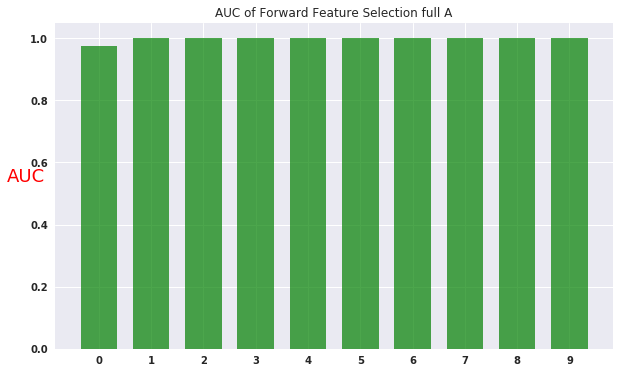

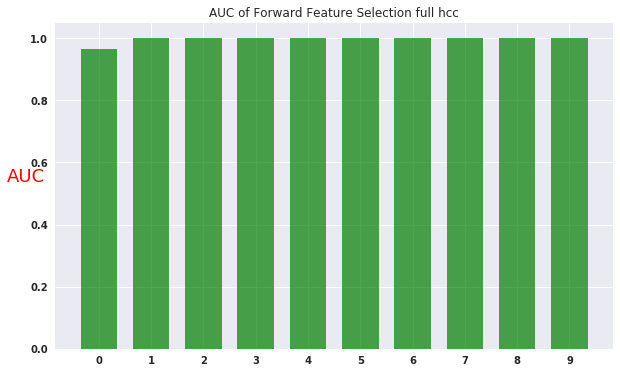

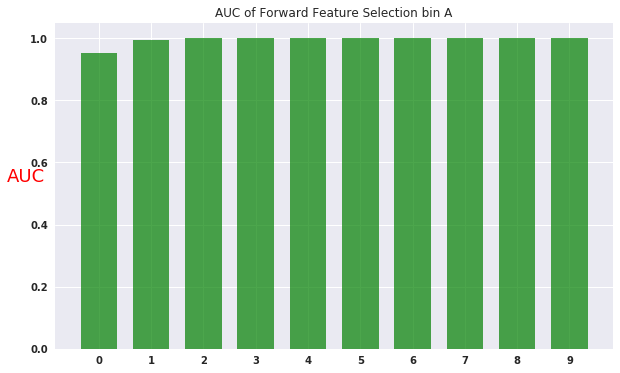

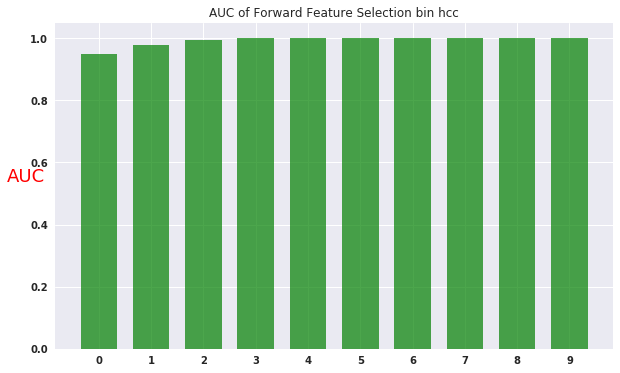

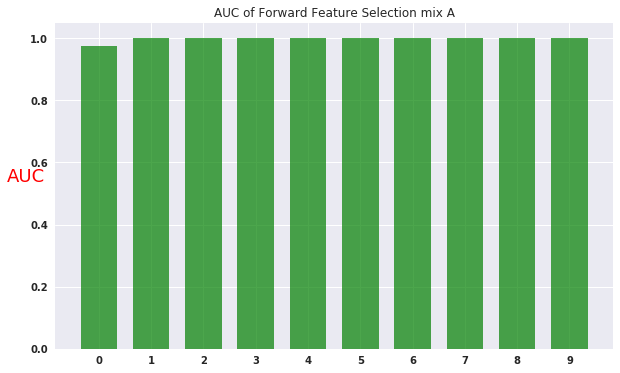

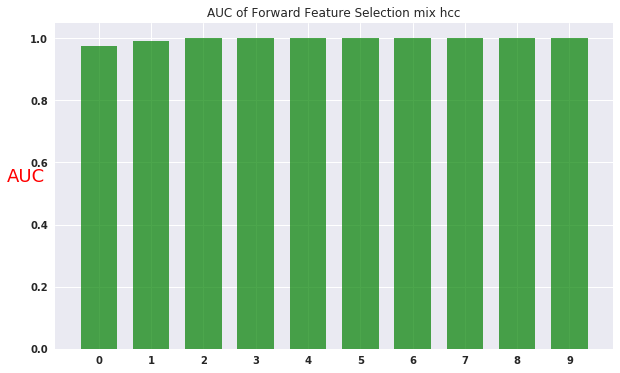

In [789]:
for i in range(3):
    for j in range(2):
        plot_auc_bar(i,j)

## feature importance


In [763]:
def logistic_selection(feature,label):
    logmodel = LogisticRegression()
    logmodel.fit(feature,label)
    return logmodel.coef_

In [ ]:
dataset[datatype[i]][dataclass[j]][:,
                         np.flip(rfefeatureind[i][j].astype('int')[-50:],axis=0)[pickedind[i][j]]]

In [764]:
styles = ["white","dark",'whitegrid',"darkgrid"]
contexts = ['paper','talk','poster','notebook']
sns.set_style(styles[0])
sns.set_context(contexts[2])

In [765]:
def featureimport(i,j):
    fig,ax=plt.subplots(1,figsize=(12,6))
    ranges = 20
    featuresnamessort = [fullfeaturename,binfeaturenamesplit,mixfeaturenamesplit]
    featureabs = np.abs(logistic_selection(dataset[datatype[i]][dataclass[j]][:,
                     np.flip(rfefeatureind[i][j].astype('int')[-50:],axis=0)[pickedind[i][j]]]
               ,labelset[datatype[i]][dataclass[j]])).ravel()
    featurenamessort = featuresnamessort[i][np.flip(rfefeatureind[i][j].astype('int')[-50:],axis=0)[pickedind[i][j]]][np.argsort(-featureabs)]
    ax.set_xticks(np.arange(0,ranges))
    ax.set_xticklabels(featurenamessort[:ranges],fontweight='bold')
    ax.plot(-np.sort(-featureabs)[:ranges])
    ax.set_title('Feature importance of Forward Selection '+ datatype[i]+' '+dataclass[j],fontsize=15,fontweight='bold')
    plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right',fontsize=11)
    fig.tight_layout()

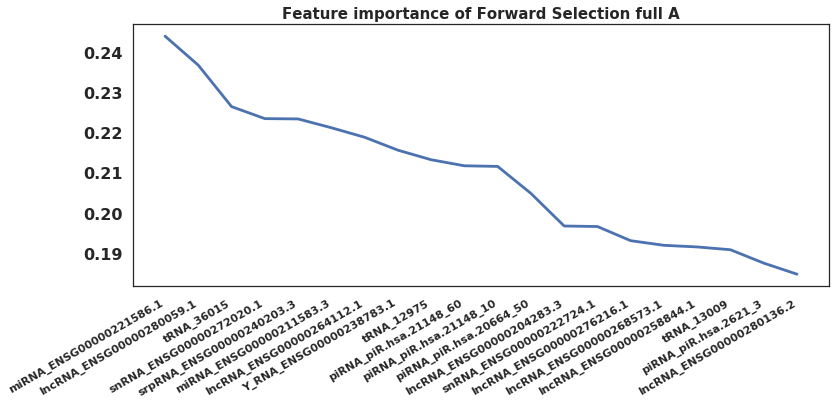

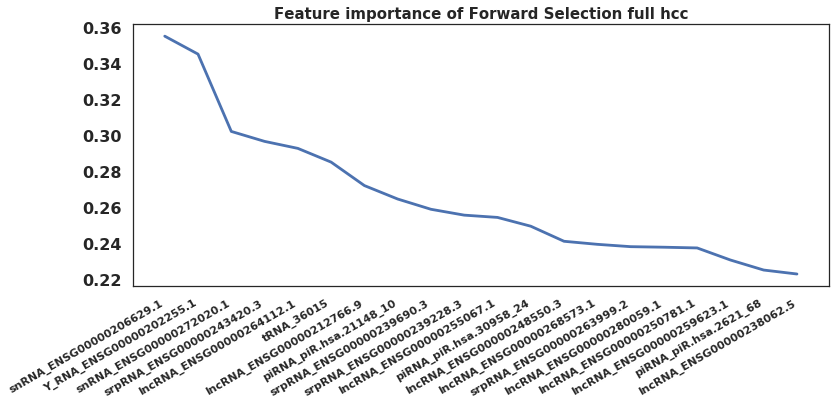

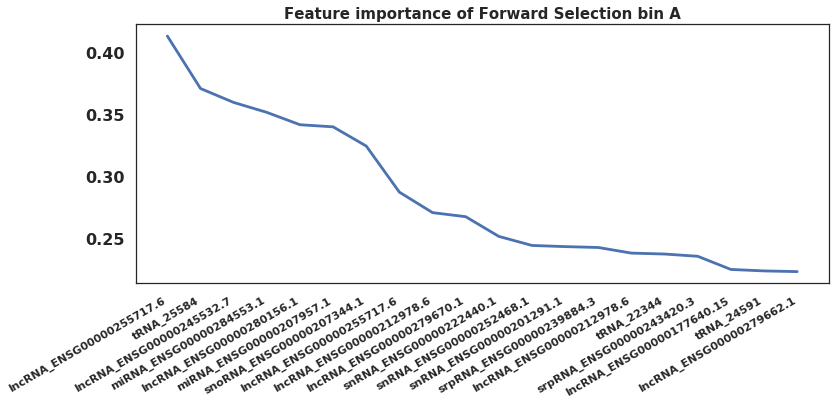

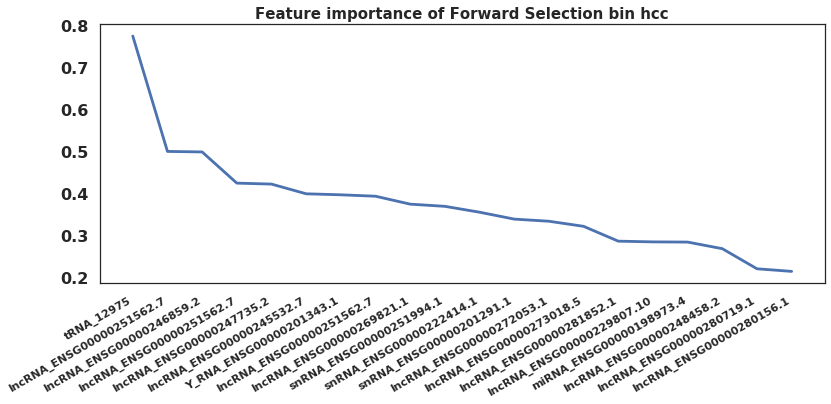

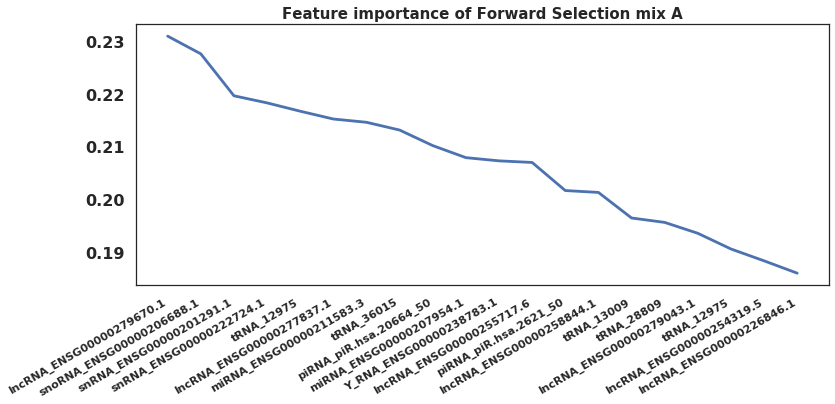

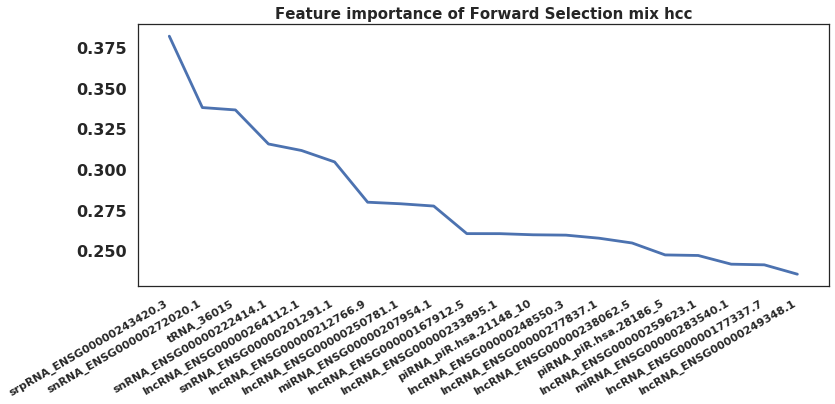

In [766]:
for i in range(3):
    for j in range(2):
        featureimport(i,j)

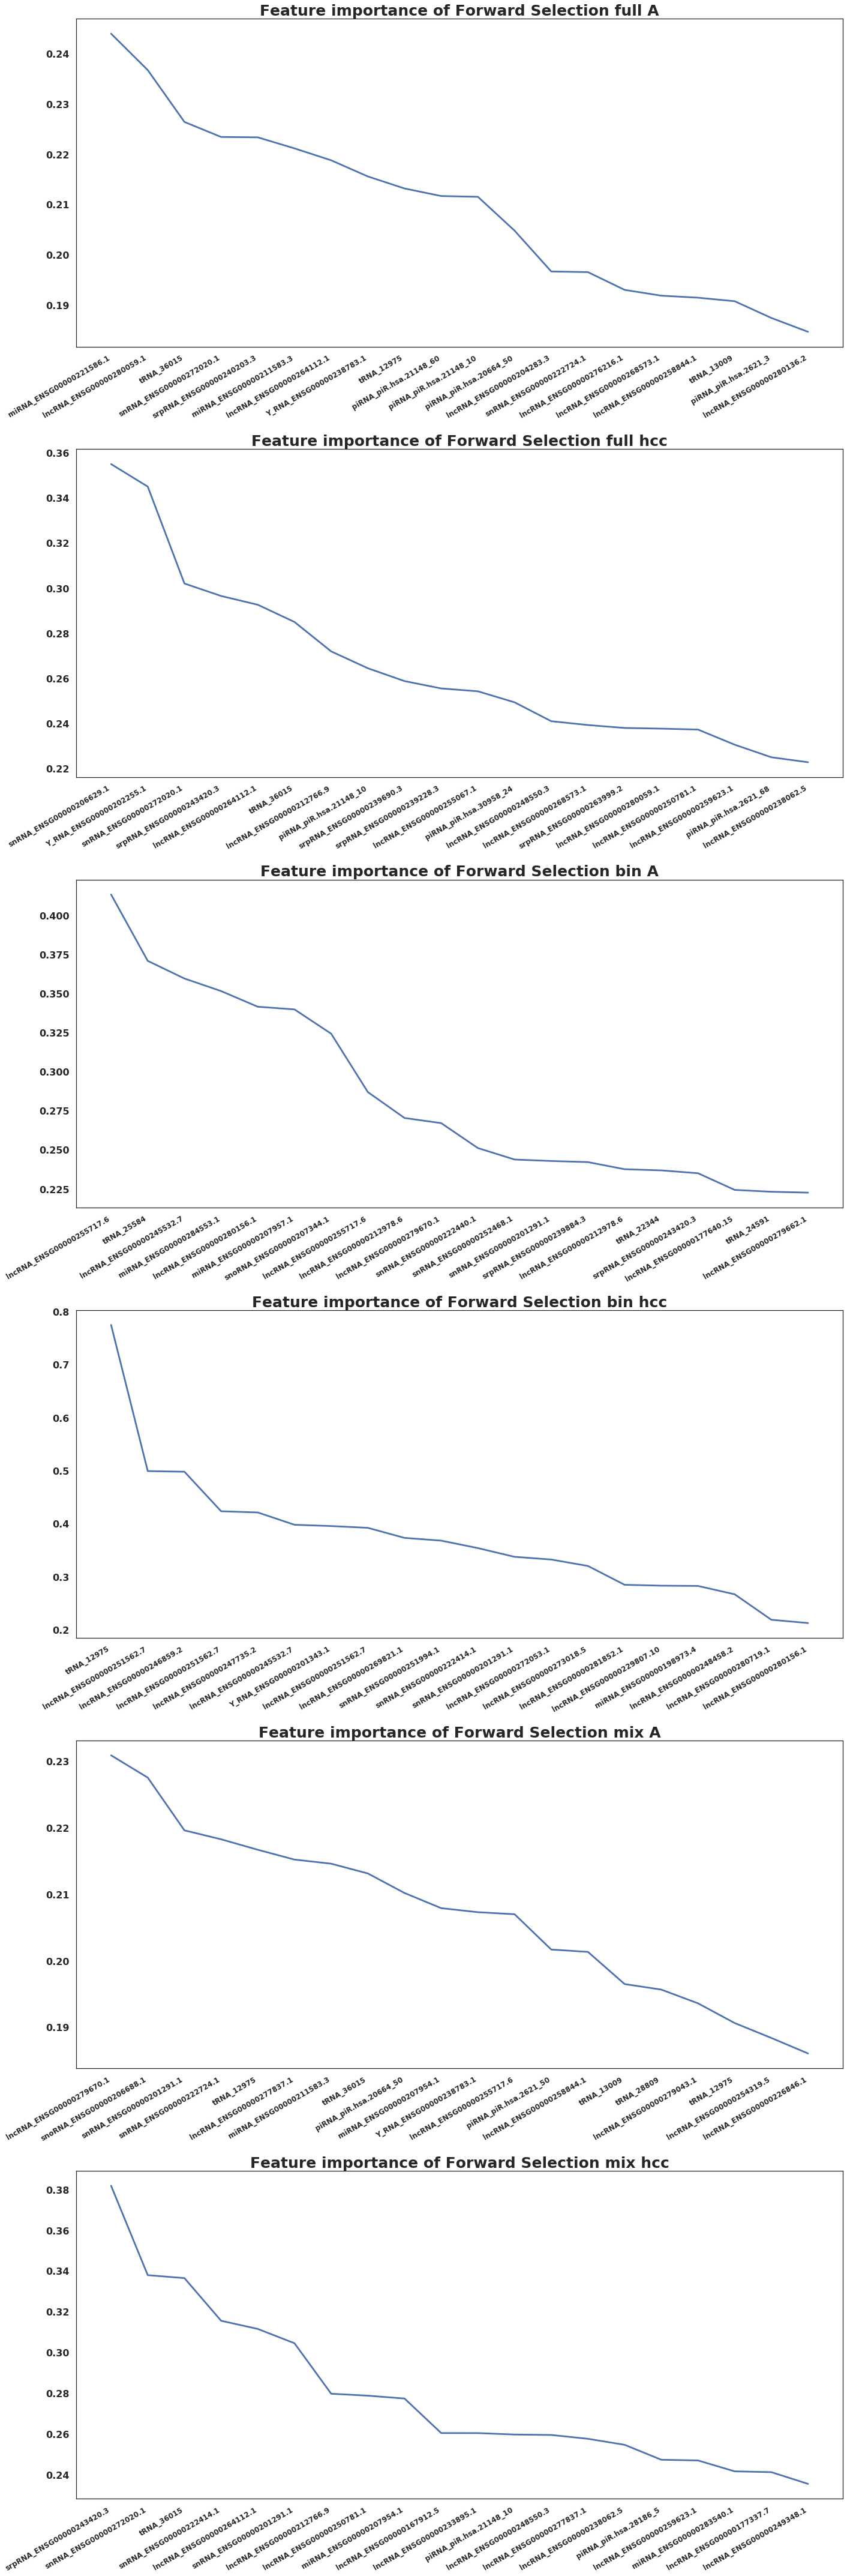

In [768]:
fig,ax=plt.subplots(6,1,figsize=(20,60))
ranges = 20
featuresnamessort = [fullfeaturename,binfeaturenamesplit,mixfeaturenamesplit]
for i in range(3):
    for j in range(2):
        featureabs = np.abs(logistic_selection(dataset[datatype[i]][dataclass[j]][:,
                         np.flip(rfefeatureind[i][j].astype('int')[-50:],axis=0)[pickedind[i][j]]]
                   ,labelset[datatype[i]][dataclass[j]])).ravel()
        featurenamessort = featuresnamessort[i][np.flip(rfefeatureind[i][j].astype('int')[-50:],axis=0)[pickedind[i][j]]][np.argsort(-featureabs)]
        ax[i*2+j].set_xticks(np.arange(0,ranges))
        ax[i*2+j].set_xticklabels(featurenamessort[:ranges],fontweight='bold')
        ax[i*2+j].plot(-np.sort(-featureabs)[:ranges])
        ax[i*2+j].set_title('Feature importance of Forward Selection '+ datatype[i]+' '+dataclass[j],fontsize=25,fontweight='bold')
        plt.setp(ax[i*2+j].get_xticklabels(), rotation=30, horizontalalignment='right',fontsize=12)
        fig.tight_layout()

##   clsutering

In [649]:
stageAnormallabel = np.repeat('sA',29)
stageAnormallabel[labelset[datatype[0]][dataclass[0]].ravel()==0] = 'HD'

In [769]:
stageAnormallabel

array(['sA', 'sA', 'sA', 'sA', 'sA', 'sA', 'sA', 'sA', 'sA', 'sA', 'sA',
       'sA', 'sA', 'sA', 'sA', 'sA', 'HD', 'HD', 'HD', 'HD', 'HD', 'HD',
       'HD', 'HD', 'HD', 'HD', 'HD', 'HD', 'HD'], dtype='<U2')

In [770]:
def cluster_plot(i,j,width=20,height=20):
    rc('font', weight='bold')
    sns.set(font_scale=1)
    if j ==0:
        columns1 = stageAnormallabel
        width = 12
        height = 22
    elif j==1:
        columns1 = samplecolumns.ravel()
        width = 20
        height = 25
    if i ==0:
        index1 = fullfeaturename[np.flip(rfefeatureind[i][j].astype('int')[-50:],axis=0)[pickedind[i][j]]]
    elif i==1:
        index1 =binfeaturenamesplit[np.flip(rfefeatureind[i][j].astype('int')[-50:],axis=0)[pickedind[i][j]]]
    elif i==2:
        index1 =mixfeaturenamesplit[np.flip(rfefeatureind[i][j].astype('int')[-50:],axis=0)[pickedind[i][j]]]
        
    table = pd.DataFrame(dataset[datatype[i]][dataclass[j]][:,
                             np.flip(rfefeatureind[i][j].astype('int')[-50:],axis=0)[pickedind[i][j]]].T,
                         columns=columns1,index = index1)
    print (table.shape)
    
    cg = sns.clustermap(table,center=0,cmap="vlag",linewidths=.75,figsize=(width,height))
    
    plt.xticks(rotation=0,fontweight='bold') 
    plt.yticks(rotation='vertical',fontweight='bold')
    plt.title('Cluster '+ datatype[i]+' '+dataclass[j],loc ='center')

(50, 29)
(50, 43)
(50, 29)
(50, 43)
(50, 29)
(50, 43)


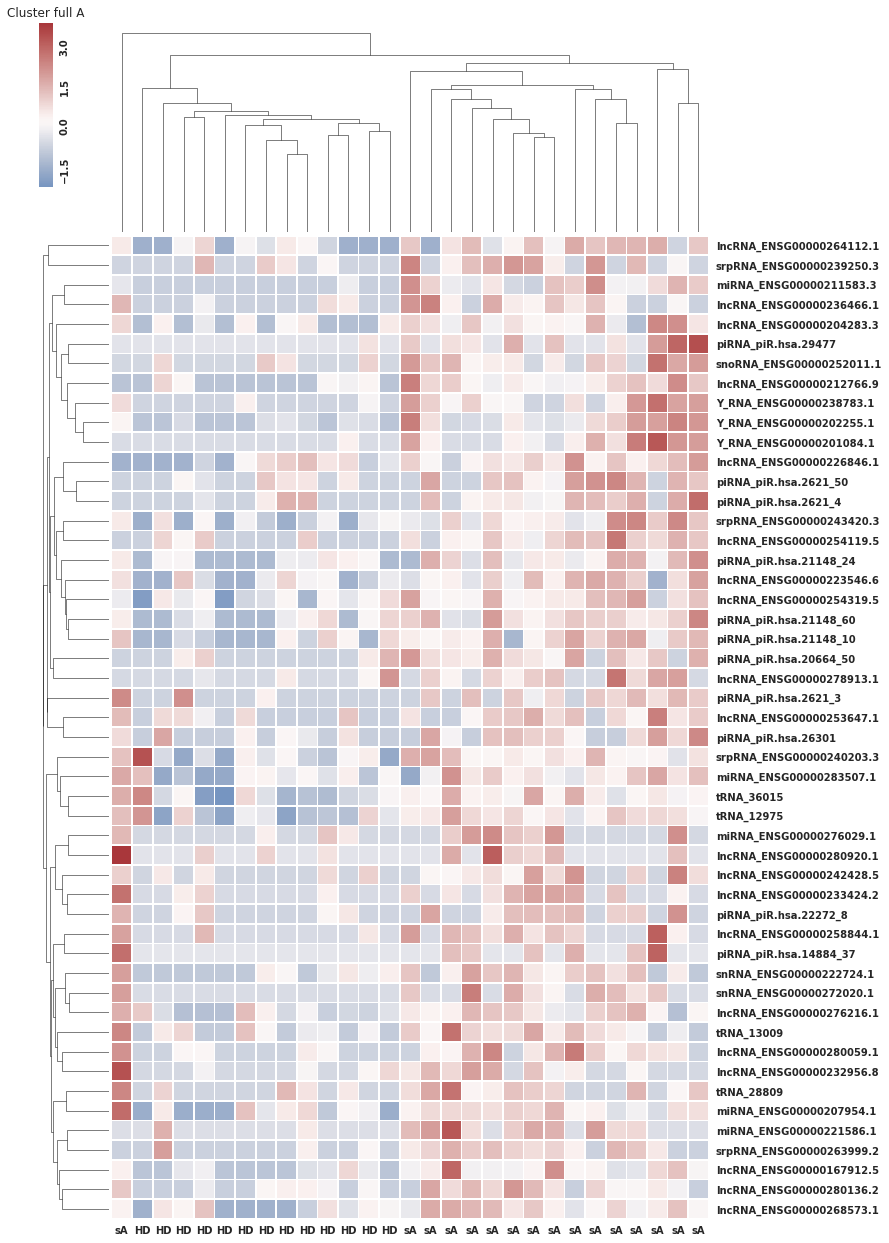

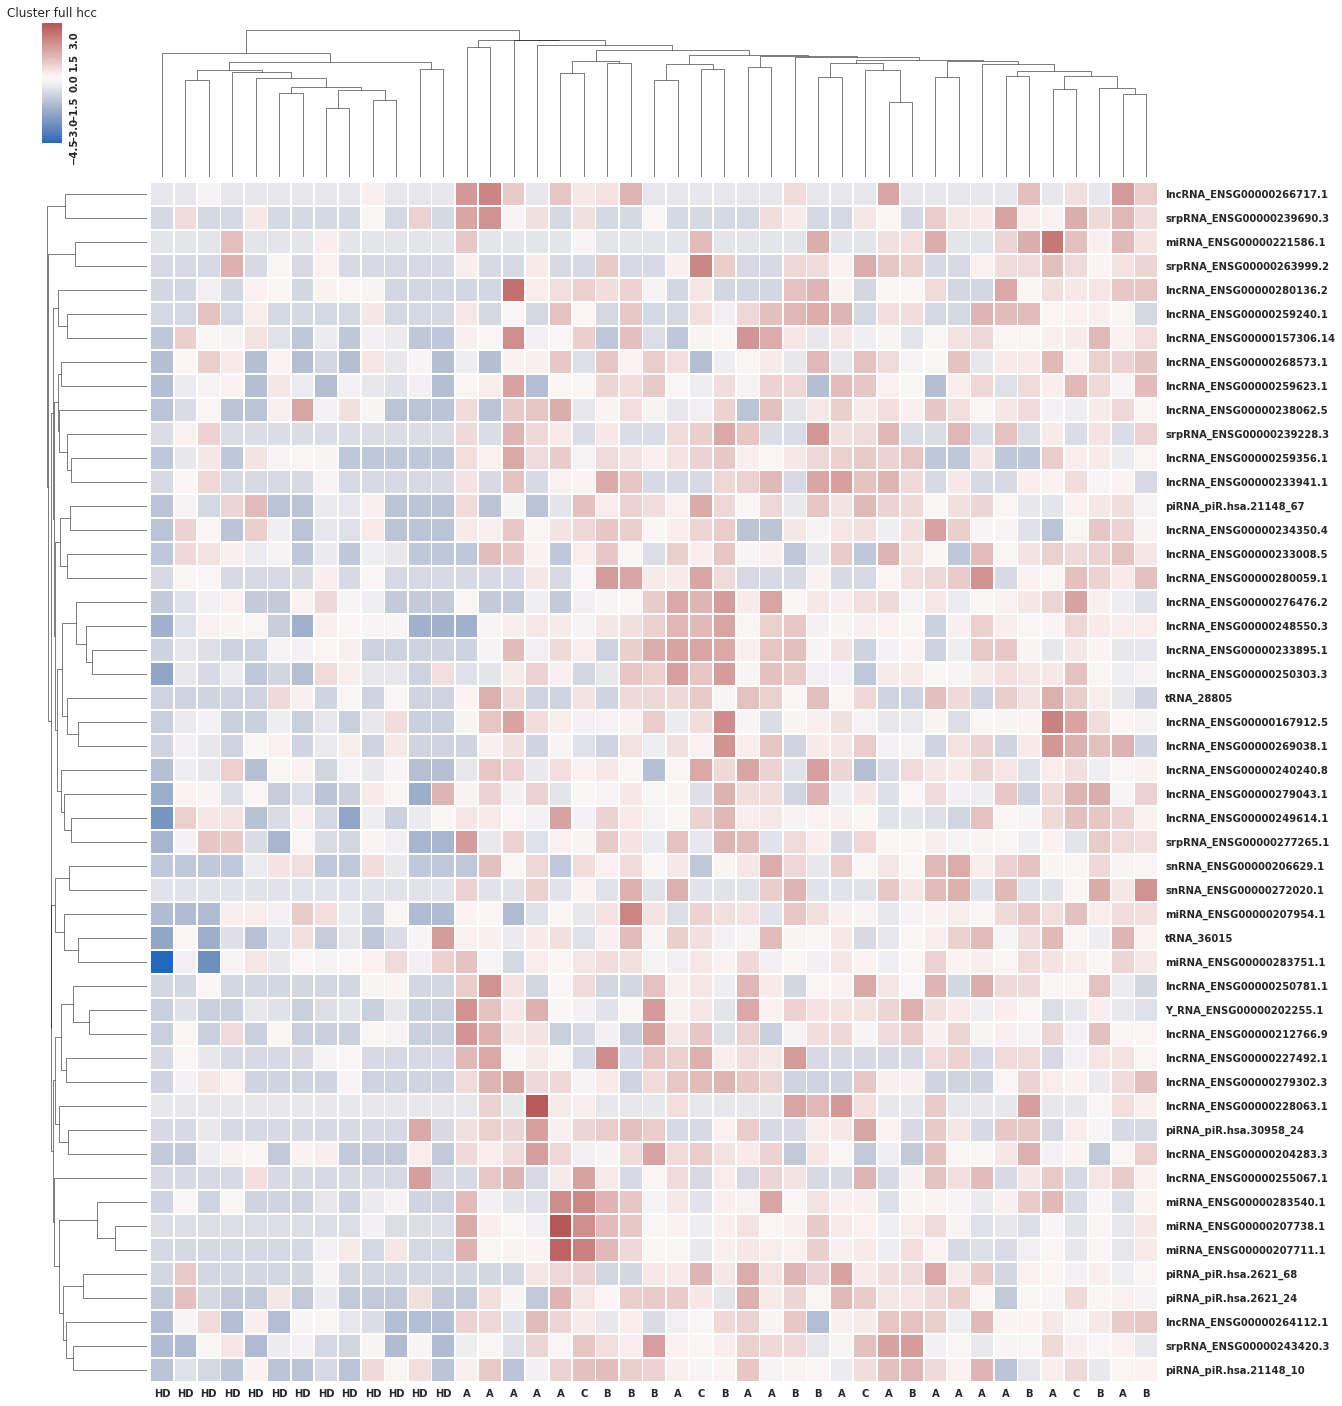

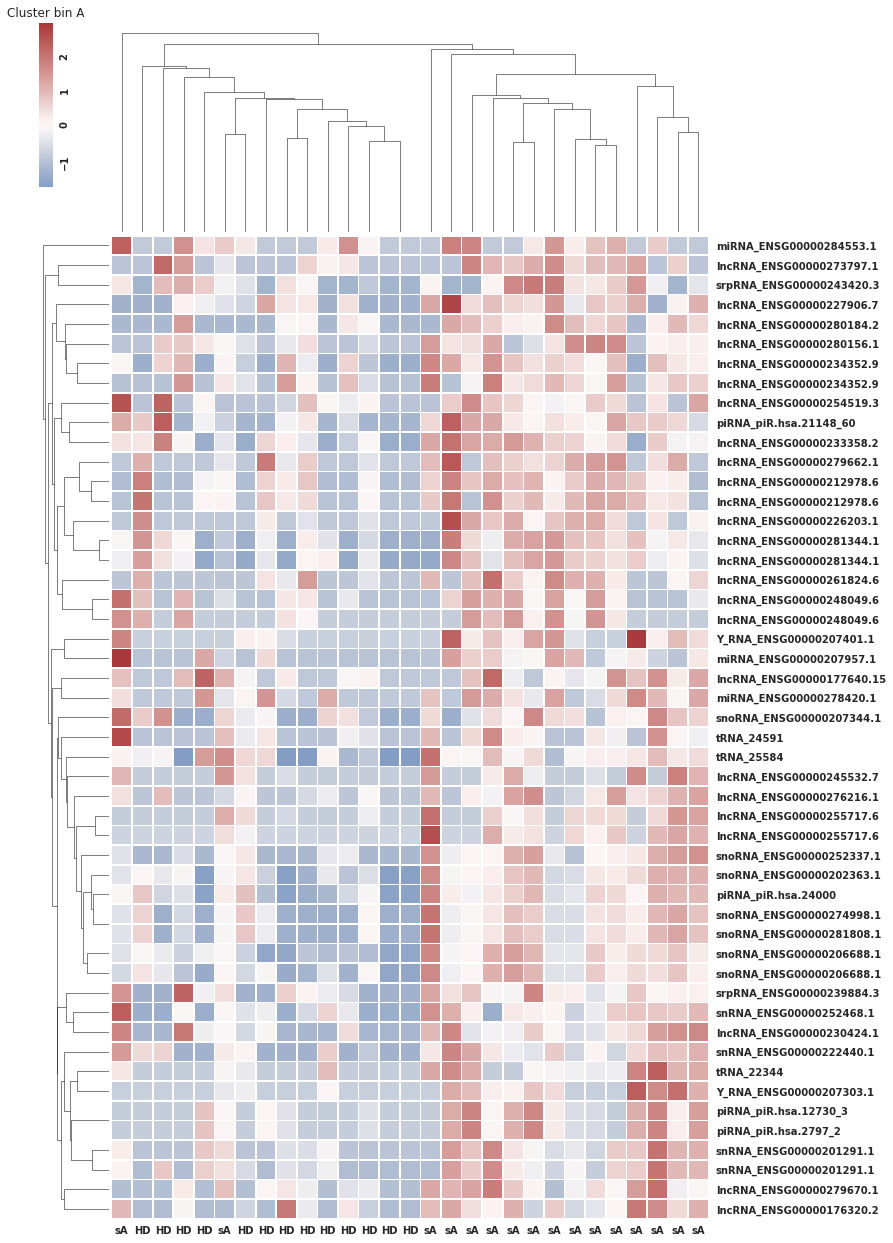

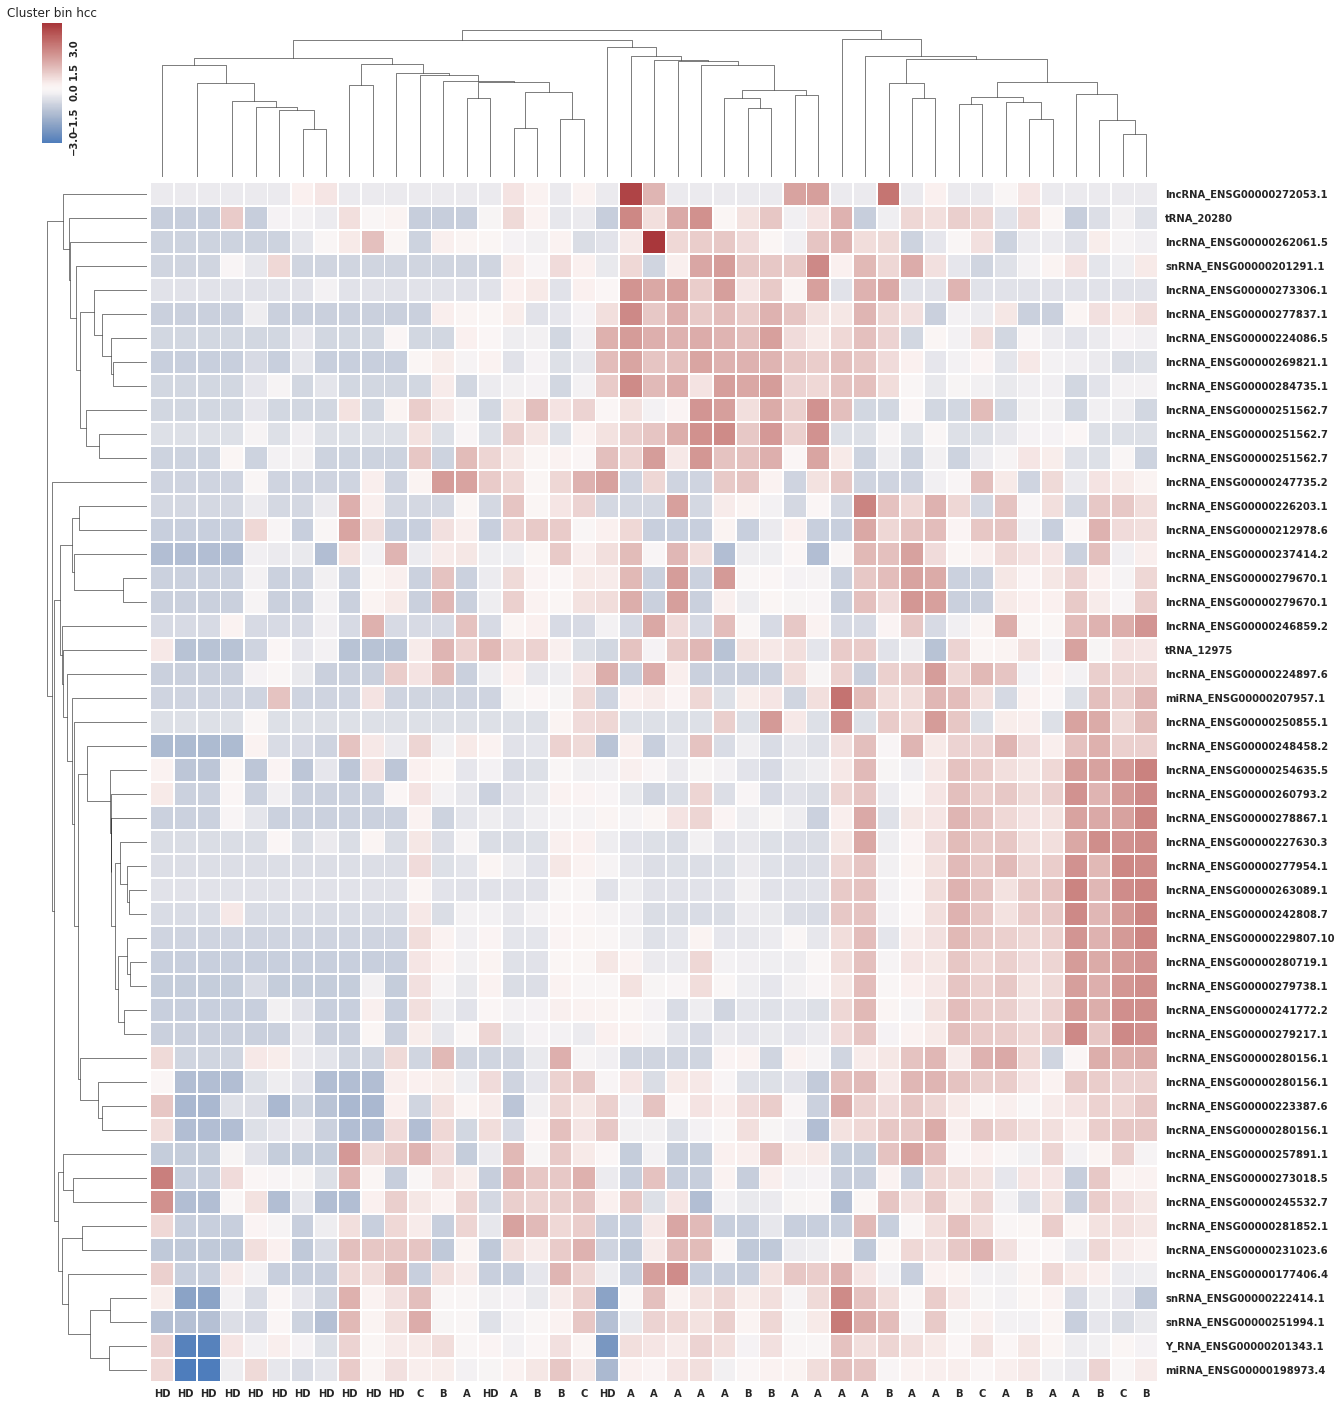

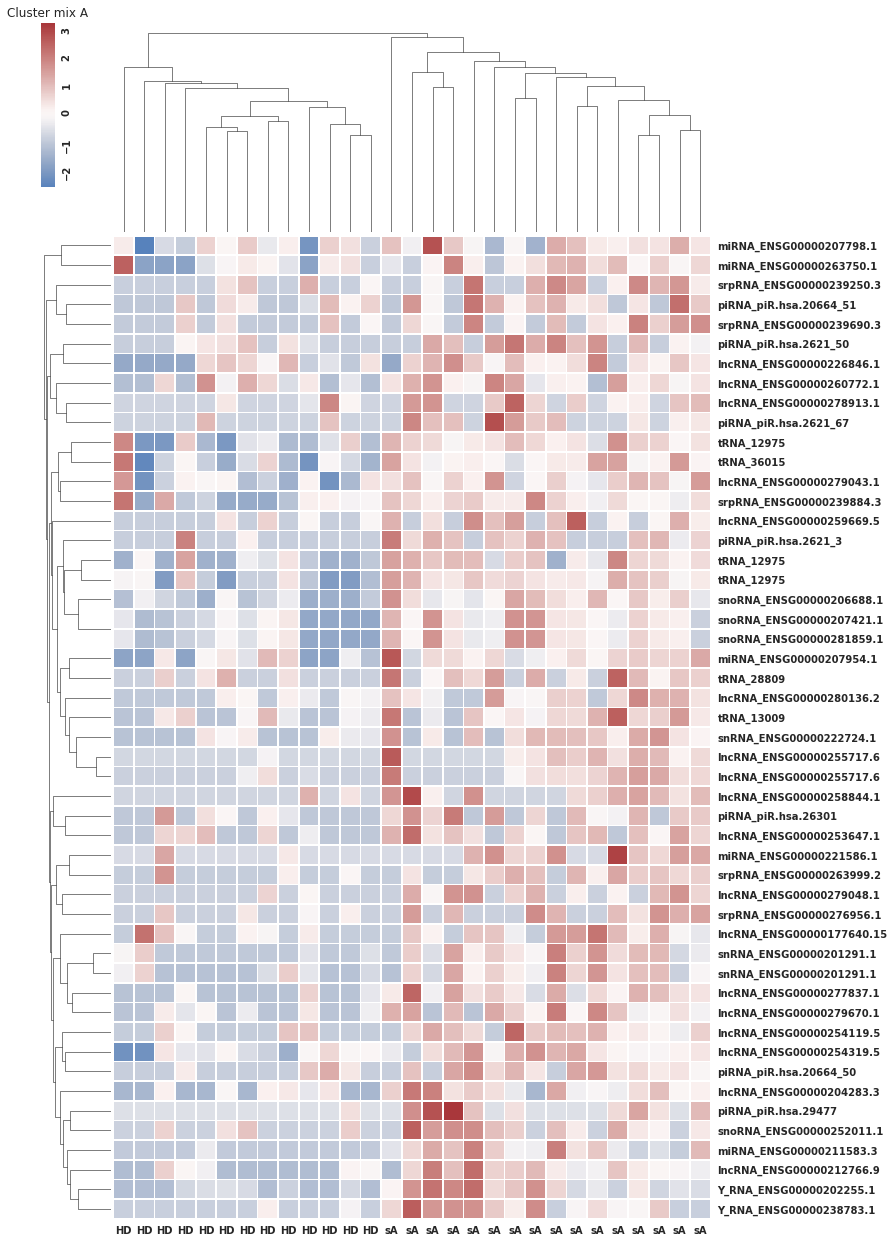

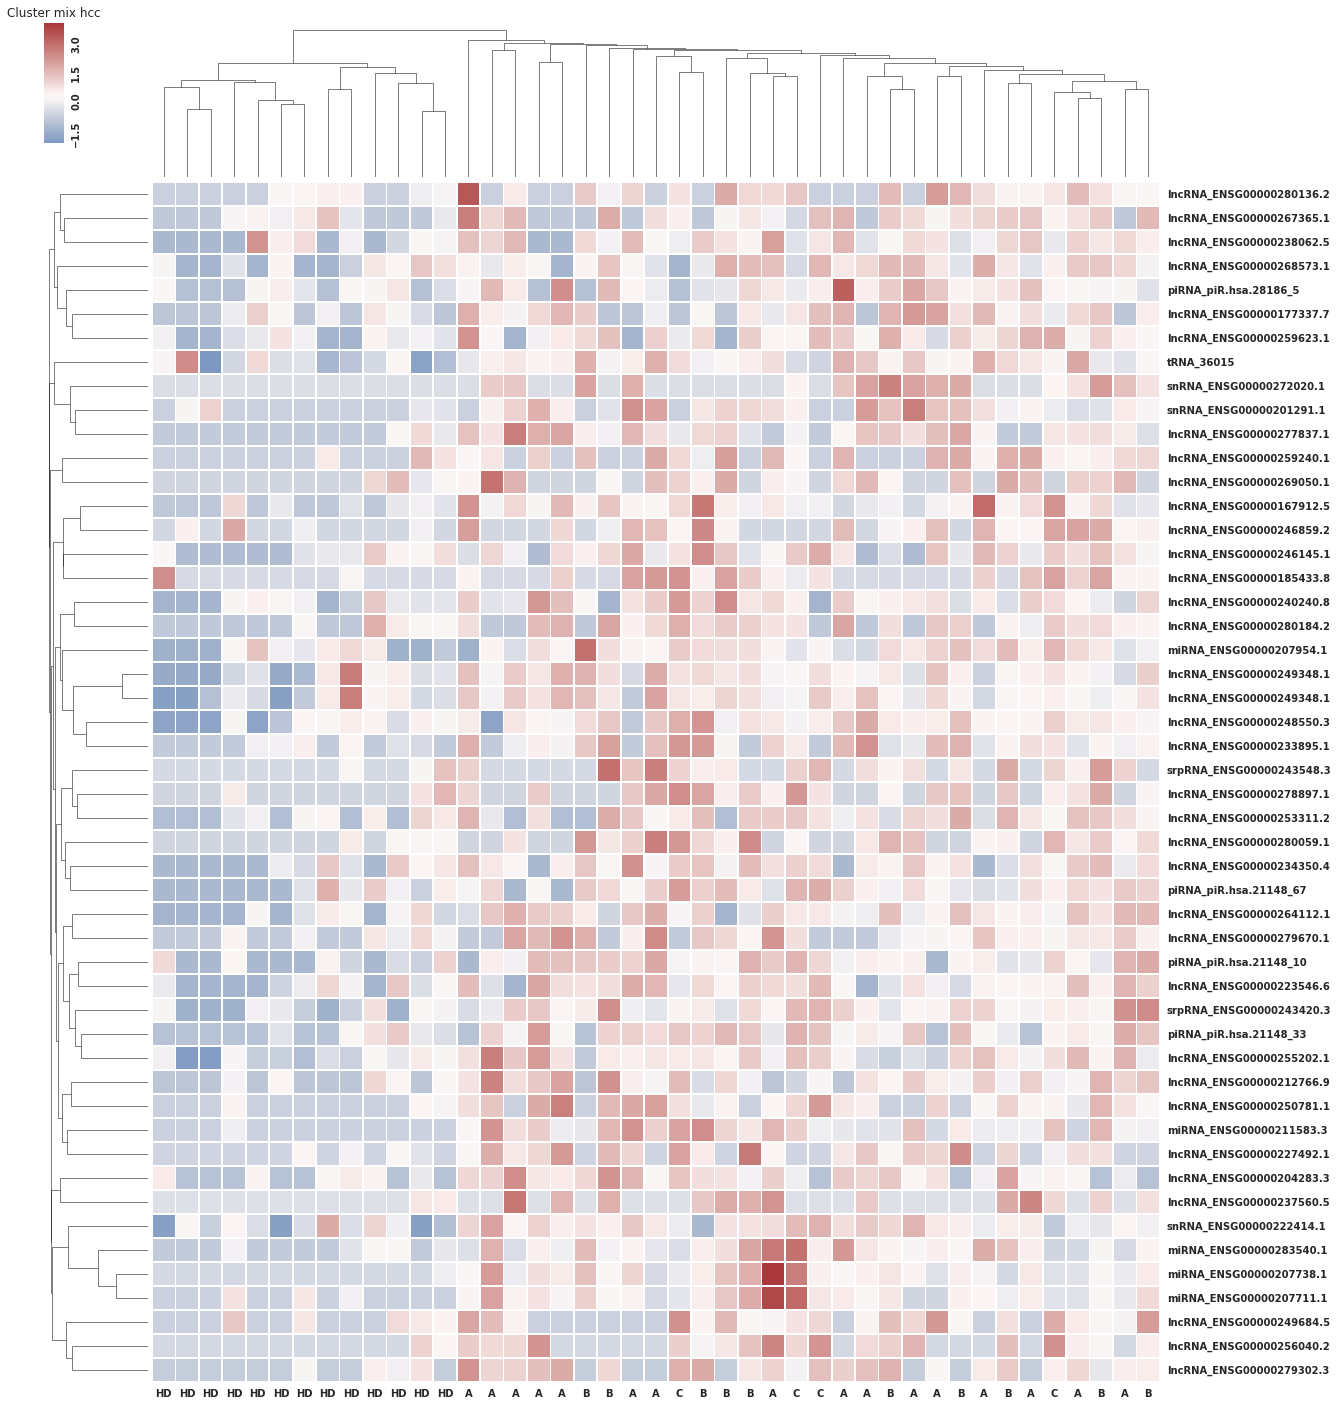

In [771]:
for i in range(3):
    for j in range(2):
        cluster_plot(i,j)

## 然后比较挑出来的feature的交集和并集，尤其是bin和full的交集！

In [772]:
fullfeaturename.shape

(10289,)

In [773]:
for i in range(3):
    for j in range(2):
        print (dataset[datatype[i]][dataclass[j]].shape)

(29, 10289)
(43, 10289)
(29, 15823)
(43, 15823)
(29, 26112)
(43, 26112)


In [774]:
fullfeaturename.shape, binfeaturename.shape, mixfeaturename.shape

((10289,), (15823,), (26112,))

In [775]:
selected_feature_name = {}
for i in range(3):
    selected_feature_name[i] = {}
    for j in range(2):
        if i ==0:
            selected_feature_name[i][j] = fullfeaturename[np.flip(rfefeatureind[i][j].astype('int')[-50:],axis=0)[pickedind[i][j]]]
        if i ==1:
            selected_feature_name[i][j] = binfeaturename[np.flip(rfefeatureind[i][j].astype('int')[-50:],axis=0)[pickedind[i][j]]]
        if i ==2:
            selected_feature_name[i][j] = mixfeaturename[np.flip(rfefeatureind[i][j].astype('int')[-50:],axis=0)[pickedind[i][j]]]
tablefeature = pd.DataFrame([])
for i in range(3):
    for j in range(2):
        tablefeature =pd.concat((tablefeature,pd.DataFrame(selected_feature_name[i][j])),axis=1)
tablefeature.columns = ['Full A','Full HCC','Bin A','Bin HCC','Mix A','Mix HCC']

In [776]:
np.intersect1d(tablefeature.iloc[:,0],tablefeature.iloc[:,1])

array(['Y_RNA_ENSG00000202255.1', 'lncRNA_ENSG00000167912.5',
       'lncRNA_ENSG00000204283.3', 'lncRNA_ENSG00000212766.9',
       'lncRNA_ENSG00000264112.1', 'lncRNA_ENSG00000268573.1',
       'lncRNA_ENSG00000280059.1', 'lncRNA_ENSG00000280136.2',
       'miRNA_ENSG00000207954.1', 'miRNA_ENSG00000221586.1',
       'piRNA_piR.hsa.21148_10', 'snRNA_ENSG00000272020.1',
       'srpRNA_ENSG00000243420.3', 'srpRNA_ENSG00000263999.2',
       'tRNA_36015'], dtype=object)

In [777]:
tablefeature

,Full A,Full HCC,Bin A,Bin HCC,Mix A,Mix HCC
0,miRNA_ENSG00000211583.3,miRNA_ENSG00000207738.1,snoRNA_ENSG00000206688.1__25085400__25085430,lncRNA_ENSG00000263089.1__57095505__57095535,miRNA_ENSG00000211583.3,miRNA_ENSG00000211583.3
1,lncRNA_ENSG00000280136.2,Y_RNA_ENSG00000202255.1,tRNA_22344__155463856__155463886,lncRNA_ENSG00000251562.7__65503027__65503057,lncRNA_ENSG00000280136.2,lncRNA_ENSG00000227492.1
2,miRNA_ENSG00000221586.1,srpRNA_ENSG00000243420.3,miRNA_ENSG00000284553.1__11113474__11113504,Y_RNA_ENSG00000201343.1__177120751__177120781,lncRNA_ENSG00000254319.5,srpRNA_ENSG00000243420.3
3,piRNA_piR.hsa.21148_60,lncRNA_ENSG00000167912.5,lncRNA_ENSG00000280156.1__16999661__16999691,tRNA_12975__27290656__27290686,piRNA_piR.hsa.26301,snRNA_ENSG00000201291.1__75473813__75473843
4,lncRNA_ENSG00000264112.1,piRNA_piR.hsa.21148_10,snRNA_ENSG00000201291.1__75473813__75473843,lncRNA_ENSG00000251562.7__65504521__65504551,piRNA_piR.hsa.20664_51,snRNA_ENSG00000222414.1__101364890__101364920
5,lncRNA_ENSG00000223546.6,lncRNA_ENSG00000264112.1,lncRNA_ENSG00000177640.15__118209761__118209791,lncRNA_ENSG00000246859.2__111732636__111732666,piRNA_piR.hsa.20664_50,snRNA_ENSG00000272020.1
6,lncRNA_ENSG00000268573.1,lncRNA_ENSG00000249614.1,snRNA_ENSG00000252468.1__5019196__5019226,lncRNA_ENSG00000272053.1__25015177__25015207,piRNA_piR.hsa.29477,lncRNA_ENSG00000264112.1
7,piRNA_piR.hsa.21148_10,piRNA_piR.hsa.2621_68,srpRNA_ENSG00000239884.3__2680958__2680988,lncRNA_ENSG00000269821.1__2680073__2680103,lncRNA_ENSG00000278913.1,miRNA_ENSG00000207954.1
8,lncRNA_ENSG00000233424.2,piRNA_piR.hsa.21148_67,lncRNA_ENSG00000212978.6__61143152__61143182,lncRNA_ENSG00000251562.7__65500582__65500612,lncRNA_ENSG00000258844.1,tRNA_36015
9,tRNA_36015,miRNA_ENSG00000207711.1,lncRNA_ENSG00000279670.1__21892698__21892728,miRNA_ENSG00000198973.4__219001645__219001675,miRNA_ENSG00000221586.1,lncRNA_ENSG00000280136.2


In [778]:
selected_feature_name_split = {}
for i in range(3):
    selected_feature_name_split[i] = {}
    for j in range(2):
        if i ==0:
            selected_feature_name_split[i][j] = fullfeaturename[np.flip(rfefeatureind[i][j].astype('int')[-50:],axis=0)[pickedind[i][j]]]
        if i ==1:
            selected_feature_name_split[i][j] = binfeaturenamesplit[np.flip(rfefeatureind[i][j].astype('int')[-50:],axis=0)[pickedind[i][j]]]
        if i ==2:
            selected_feature_name_split[i][j] = mixfeaturenamesplit[np.flip(rfefeatureind[i][j].astype('int')[-50:],axis=0)[pickedind[i][j]]]
tablefeature_split = pd.DataFrame([])
for i in range(3):
    for j in range(2):
        tablefeature_split =pd.concat((tablefeature_split,pd.DataFrame(selected_feature_name_split[i][j])),axis=1)
tablefeature_split.columns = ['Full A','Full HCC','Bin A','Bin HCC','Mix A','Mix HCC']

In [779]:
tablefeature_split

,Full A,Full HCC,Bin A,Bin HCC,Mix A,Mix HCC
0,miRNA_ENSG00000211583.3,miRNA_ENSG00000207738.1,snoRNA_ENSG00000206688.1,lncRNA_ENSG00000263089.1,miRNA_ENSG00000211583.3,miRNA_ENSG00000211583.3
1,lncRNA_ENSG00000280136.2,Y_RNA_ENSG00000202255.1,tRNA_22344,lncRNA_ENSG00000251562.7,lncRNA_ENSG00000280136.2,lncRNA_ENSG00000227492.1
2,miRNA_ENSG00000221586.1,srpRNA_ENSG00000243420.3,miRNA_ENSG00000284553.1,Y_RNA_ENSG00000201343.1,lncRNA_ENSG00000254319.5,srpRNA_ENSG00000243420.3
3,piRNA_piR.hsa.21148_60,lncRNA_ENSG00000167912.5,lncRNA_ENSG00000280156.1,tRNA_12975,piRNA_piR.hsa.26301,snRNA_ENSG00000201291.1
4,lncRNA_ENSG00000264112.1,piRNA_piR.hsa.21148_10,snRNA_ENSG00000201291.1,lncRNA_ENSG00000251562.7,piRNA_piR.hsa.20664_51,snRNA_ENSG00000222414.1
5,lncRNA_ENSG00000223546.6,lncRNA_ENSG00000264112.1,lncRNA_ENSG00000177640.15,lncRNA_ENSG00000246859.2,piRNA_piR.hsa.20664_50,snRNA_ENSG00000272020.1
6,lncRNA_ENSG00000268573.1,lncRNA_ENSG00000249614.1,snRNA_ENSG00000252468.1,lncRNA_ENSG00000272053.1,piRNA_piR.hsa.29477,lncRNA_ENSG00000264112.1
7,piRNA_piR.hsa.21148_10,piRNA_piR.hsa.2621_68,srpRNA_ENSG00000239884.3,lncRNA_ENSG00000269821.1,lncRNA_ENSG00000278913.1,miRNA_ENSG00000207954.1
8,lncRNA_ENSG00000233424.2,piRNA_piR.hsa.21148_67,lncRNA_ENSG00000212978.6,lncRNA_ENSG00000251562.7,lncRNA_ENSG00000258844.1,tRNA_36015
9,tRNA_36015,miRNA_ENSG00000207711.1,lncRNA_ENSG00000279670.1,miRNA_ENSG00000198973.4,miRNA_ENSG00000221586.1,lncRNA_ENSG00000280136.2


In [780]:
np.intersect1d(tablefeature_split.iloc[:,2],tablefeature_split.iloc[:,3])

array(['lncRNA_ENSG00000212978.6', 'lncRNA_ENSG00000226203.1',
       'lncRNA_ENSG00000245532.7', 'lncRNA_ENSG00000279670.1',
       'lncRNA_ENSG00000280156.1', 'miRNA_ENSG00000207957.1',
       'snRNA_ENSG00000201291.1'], dtype=object)

In [781]:
np.intersect1d(tablefeature_split.iloc[:,4],tablefeature_split.iloc[:,5])

array(['lncRNA_ENSG00000204283.3', 'lncRNA_ENSG00000212766.9',
       'lncRNA_ENSG00000277837.1', 'lncRNA_ENSG00000279670.1',
       'lncRNA_ENSG00000280136.2', 'miRNA_ENSG00000207954.1',
       'miRNA_ENSG00000211583.3', 'snRNA_ENSG00000201291.1', 'tRNA_36015'],
      dtype=object)

In [782]:
np.intersect1d(tablefeature_split.iloc[:,0],tablefeature_split.iloc[:,3])

array(['tRNA_12975'], dtype=object)

In [783]:
uniquefeature, unicounts  = np.unique(tablefeature_split,return_counts=True)
uniquefeature[unicounts>1]
unicounts[unicounts>1]

array([3, 2, 3, 2, 4, 4, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       3, 2, 2, 2, 4, 2, 2, 2, 3, 3, 2, 3, 2, 2, 2, 5, 3, 4, 4, 2, 2, 2,
       2, 4, 2, 3, 3, 2, 2, 3, 2, 2, 2, 2, 2, 2, 6, 2, 2, 3, 3, 2, 2, 2,
       2, 4, 3, 5, 2, 2, 4])

In [784]:
np.concatenate((uniquefeature[unicounts>1].reshape(-1,1),unicounts[unicounts>1].reshape(-1,1)),axis=1).shape

(73, 2)

In [785]:
pd.DataFrame(np.concatenate((uniquefeature[np.argsort(-unicounts)].reshape(-1,1),
                             unicounts[np.argsort(-unicounts)].reshape(-1,1)),axis=1)[:-1].reshape(-1,6)
            ,columns=['geneid','frequency','geneid','frequency','geneid','frequency'])

,geneid,frequency,geneid,frequency,geneid,frequency
0,snRNA_ENSG00000201291.1,6,tRNA_12975,5,lncRNA_ENSG00000279670.1,5
1,tRNA_36015,4,lncRNA_ENSG00000212766.9,4,lncRNA_ENSG00000204283.3,4
2,lncRNA_ENSG00000280136.2,4,lncRNA_ENSG00000280156.1,4,lncRNA_ENSG00000255717.6,4
3,miRNA_ENSG00000207954.1,4,srpRNA_ENSG00000243420.3,4,miRNA_ENSG00000221586.1,3
4,piRNA_piR.hsa.21148_10,3,snRNA_ENSG00000272020.1,3,snoRNA_ENSG00000206688.1,3
5,lncRNA_ENSG00000280059.1,3,srpRNA_ENSG00000263999.2,3,lncRNA_ENSG00000268573.1,3
6,lncRNA_ENSG00000264112.1,3,miRNA_ENSG00000211583.3,3,lncRNA_ENSG00000251562.7,3
7,lncRNA_ENSG00000277837.1,3,lncRNA_ENSG00000167912.5,3,Y_RNA_ENSG00000202255.1,3
8,lncRNA_ENSG00000212978.6,3,lncRNA_ENSG00000227492.1,2,lncRNA_ENSG00000223546.6,2
9,piRNA_piR.hsa.2621_50,2,piRNA_piR.hsa.26301,2,piRNA_piR.hsa.29477,2


In [681]:
for i in range(6):
    for j in np.setdiff1d(np.arange(0,6),i):
        print (['Full A','Full HCC','Bin A','Bin HCC','Mix A','Mix HCC'][i],['Full A','Full HCC','Bin A','Bin HCC','Mix A','Mix HCC'][j])
        print (np.intersect1d(tablefeature_split.iloc[:,i],tablefeature_split.iloc[:,j]))
        print ('\n')

Full A Full HCC
['Y_RNA_ENSG00000202255.1' 'lncRNA_ENSG00000167912.5'
 'lncRNA_ENSG00000204283.3' 'lncRNA_ENSG00000212766.9'
 'lncRNA_ENSG00000264112.1' 'lncRNA_ENSG00000268573.1'
 'lncRNA_ENSG00000280059.1' 'lncRNA_ENSG00000280136.2'
 'miRNA_ENSG00000207954.1' 'miRNA_ENSG00000221586.1'
 'piRNA_piR.hsa.21148_10' 'snRNA_ENSG00000272020.1'
 'srpRNA_ENSG00000243420.3' 'srpRNA_ENSG00000263999.2' 'tRNA_36015']


Full A Bin A
['lncRNA_ENSG00000276216.1' 'piRNA_piR.hsa.21148_60'
 'srpRNA_ENSG00000243420.3']


Full A Bin HCC
['tRNA_12975']


Full A Mix A
['Y_RNA_ENSG00000202255.1' 'Y_RNA_ENSG00000238783.1'
 'lncRNA_ENSG00000204283.3' 'lncRNA_ENSG00000212766.9'
 'lncRNA_ENSG00000226846.1' 'lncRNA_ENSG00000253647.1'
 'lncRNA_ENSG00000254119.5' 'lncRNA_ENSG00000254319.5'
 'lncRNA_ENSG00000258844.1' 'lncRNA_ENSG00000278913.1'
 'lncRNA_ENSG00000280136.2' 'miRNA_ENSG00000207954.1'
 'miRNA_ENSG00000211583.3' 'miRNA_ENSG00000221586.1'
 'piRNA_piR.hsa.20664_50' 'piRNA_piR.hsa.2621_3' 'piRNA_piR.hsa.262